In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models.resnet import ResNet50_Weights
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# Конфигурационные параметры
EMBEDDING_SIZE = 256  # Размер выходного эмбеддинга
IMAGE_SIZE = 224      # Размер изображения для ResNet
BATCH_SIZE = 32       # Размер батча для обработки
MIN_CLUSTER_DISTANCE = 5.0  # Минимальное расстояние между центрами кластеров

# Путь к папке с данными
DATA_PATH = 'images_train'

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class EmbeddingExtractor(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingExtractor, self).__init__()
        # Используем актуальный способ загрузки предобученных весов
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc = nn.Linear(2048, embedding_size)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
            except:
                print(f'Error loading image {img_path}')
    return torch.stack(images)

In [6]:
def extract_folder_embeddings(model, folder_path):
    images = load_images_from_folder(folder_path)
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(images), BATCH_SIZE):
            batch = images[i:i+BATCH_SIZE].to(device)
            embeddings.append(model(batch).cpu())
    return torch.cat(embeddings, dim=0)


In [7]:
def calculate_centroids(folder_embeddings):
    return {folder: embs.mean(dim=0) for folder, embs in folder_embeddings.items()}

def ensure_cluster_separation(centroids, min_distance):
    centroid_list = torch.stack(list(centroids.values()))
    distances = cdist(centroid_list.numpy(), centroid_list.numpy(), 'euclidean')
    np.fill_diagonal(distances, np.inf)
    
    while np.any(distances < min_distance):
        for i in range(len(centroid_list)):
            for j in range(i+1, len(centroid_list)):
                if distances[i, j] < min_distance:
                    direction = centroid_list[i] - centroid_list[j]
                    direction = direction / torch.norm(direction)
                    move = (min_distance - distances[i, j]) / 2
                    centroid_list[i] += direction * move
                    centroid_list[j] -= direction * move
        
        distances = cdist(centroid_list.numpy(), centroid_list.numpy(), 'euclidean')
        np.fill_diagonal(distances, np.inf)
    
    return {folder: centroid_list[i] for i, folder in enumerate(centroids.keys())}

In [8]:
def visualize_clusters(embeddings_2d, labels, folder_names):
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddingsings_2d[:, 1], c=labels, 
                         cmap='tab20', alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter)
    plt.title('Cluster Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Добавляем центроиды
    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = labels == label
        centroid = embeddings_2d[mask].mean(axis=0)
        plt.scatter(centroid[0], centroid[1], marker='x', s=200, 
                   linewidths=3, color='black')
        plt.text(centroid[0], centroid[1], folder_names[label], 
                fontsize=9, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7))
    plt.show()

In [9]:
import random
from matplotlib import gridspec

def visualize_neighbors(embeddings, model_folders, n_samples=3, k_neighbors=5):
    """
    Визуализирует n случайных изображений и их k ближайших соседей в embedding-пространстве
    
    Args:
        embeddings: нормализованные эмбеддинги всех изображений
        model_folders: список путей к папкам с моделями
        n_samples: количество случайных изображений для анализа
        k_neighbors: количество ближайших соседей
    """
    # Собираем все изображения и их пути
    all_images = []
    image_paths = []
    
    for folder in model_folders:
        for filename in sorted(os.listdir(folder)):
            if filename.endswith('.png'):
                img_path = os.path.join(folder, filename)
                all_images.append(Image.open(img_path).convert('RGB'))
                image_paths.append(img_path)
    
    # Выбираем случайные индексы
    sample_indices = random.sample(range(len(embeddings)), n_samples)
    
    # Вычисляем попарные расстояния между всеми эмбеддингами
    distances = euclidean_distances(embeddings)
    
    for idx in sample_indices:
        # Находим k ближайших соседей (исключая само изображение)
        neighbors = np.argsort(distances[idx])[1:k_neighbors+1]
        
        # Создаем фигуру для отображения
        plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, k_neighbors+1, width_ratios=[1.2] + [1]*k_neighbors)
        
        # Отображаем исходное изображение
        plt.subplot(gs[0])
        plt.imshow(all_images[idx])
        plt.title(f"Query\n{os.path.basename(image_paths[idx])}")
        plt.axis('off')
        
        # Отображаем соседей
        for i, neighbor_idx in enumerate(neighbors, 1):
            plt.subplot(gs[i])
            plt.imshow(all_images[neighbor_idx])
            dist = distances[idx, neighbor_idx]
            plt.title(f"Dist: {dist:.2f}\n{os.path.basename(image_paths[neighbor_idx])}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [10]:
def visualize_neighbors_improved(embeddings, model_folders, n_samples=3, k_neighbors=5):
    """
    Улучшенная визуализация случайных изображений и их соседей.
    
    Args:
        embeddings: нормализованные эмбеддинги (n_samples x embedding_dim)
        model_folders: список путей к папкам с изображениями
        n_samples: количество примеров для показа
        k_neighbors: количество соседей для каждого примера
    """
    # Загружаем все изображения и их метаданные
    all_images = []
    image_paths = []
    image_labels = []
    
    for folder_idx, folder in enumerate(model_folders):
        for filename in sorted(os.listdir(folder)):
            if filename.endswith('.png'):
                img_path = os.path.join(folder, filename)
                try:
                    all_images.append(Image.open(img_path).convert('RGB'))
                    image_paths.append(img_path)
                    image_labels.append(folder_idx)
                except:
                    print(f"Error loading image: {img_path}")
    
    # Проверка соответствия размеров
    if len(all_images) != len(embeddings):
        print(f"Warning: {len(all_images)} images but {len(embeddings)} embeddings")
        return
    
    # Вычисляем матрицу расстояний
    distances = euclidean_distances(embeddings)
    
    # Выбираем случайные примеры (по одному из каждого кластера)
    unique_labels = np.unique(image_labels)
    sample_indices = []
    
    for label in unique_labels:
        mask = np.array(image_labels) == label
        available_indices = np.where(mask)[0]
        if len(available_indices) > 0:
            sample_indices.append(np.random.choice(available_indices))
        if len(sample_indices) >= n_samples:
            break
    
    # Визуализация
    for idx in sample_indices:
        # Находим k ближайших соседей
        neighbors = np.argsort(distances[idx])[1:k_neighbors+1]
        
        # Создаем фигуру
        plt.figure(figsize=(15, 3.5))
        plt.suptitle(
            f"Query image from cluster {image_labels[idx]}\n{os.path.basename(image_paths[idx])}",
            y=1.05
        )
        gs = gridspec.GridSpec(1, k_neighbors+1, width_ratios=[1.2] + [1]*k_neighbors)
        
        # Query изображение
        ax = plt.subplot(gs[0])
        ax.imshow(all_images[idx])
        ax.set_title(f"Query\nCluster {image_labels[idx]}", pad=12)
        ax.axis('off')
        
        # Соседи
        for i, neighbor_idx in enumerate(neighbors, 1):
            ax = plt.subplot(gs[i])
            ax.imshow(all_images[neighbor_idx])
            dist = distances[idx, neighbor_idx]
            ax.set_title(
                f"Dist: {dist:.2f}\nCluster {image_labels[neighbor_idx]}",
                pad=12
            )
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

Found 10 model folders
Processed folder images_train\model_1 with 26 images
Processed folder images_train\model_10 with 26 images
Processed folder images_train\model_2 with 26 images
Processed folder images_train\model_3 with 26 images
Processed folder images_train\model_4 with 26 images
Processed folder images_train\model_5 with 26 images
Processed folder images_train\model_6 with 26 images
Processed folder images_train\model_7 with 26 images
Processed folder images_train\model_8 with 26 images
Processed folder images_train\model_9 with 26 images


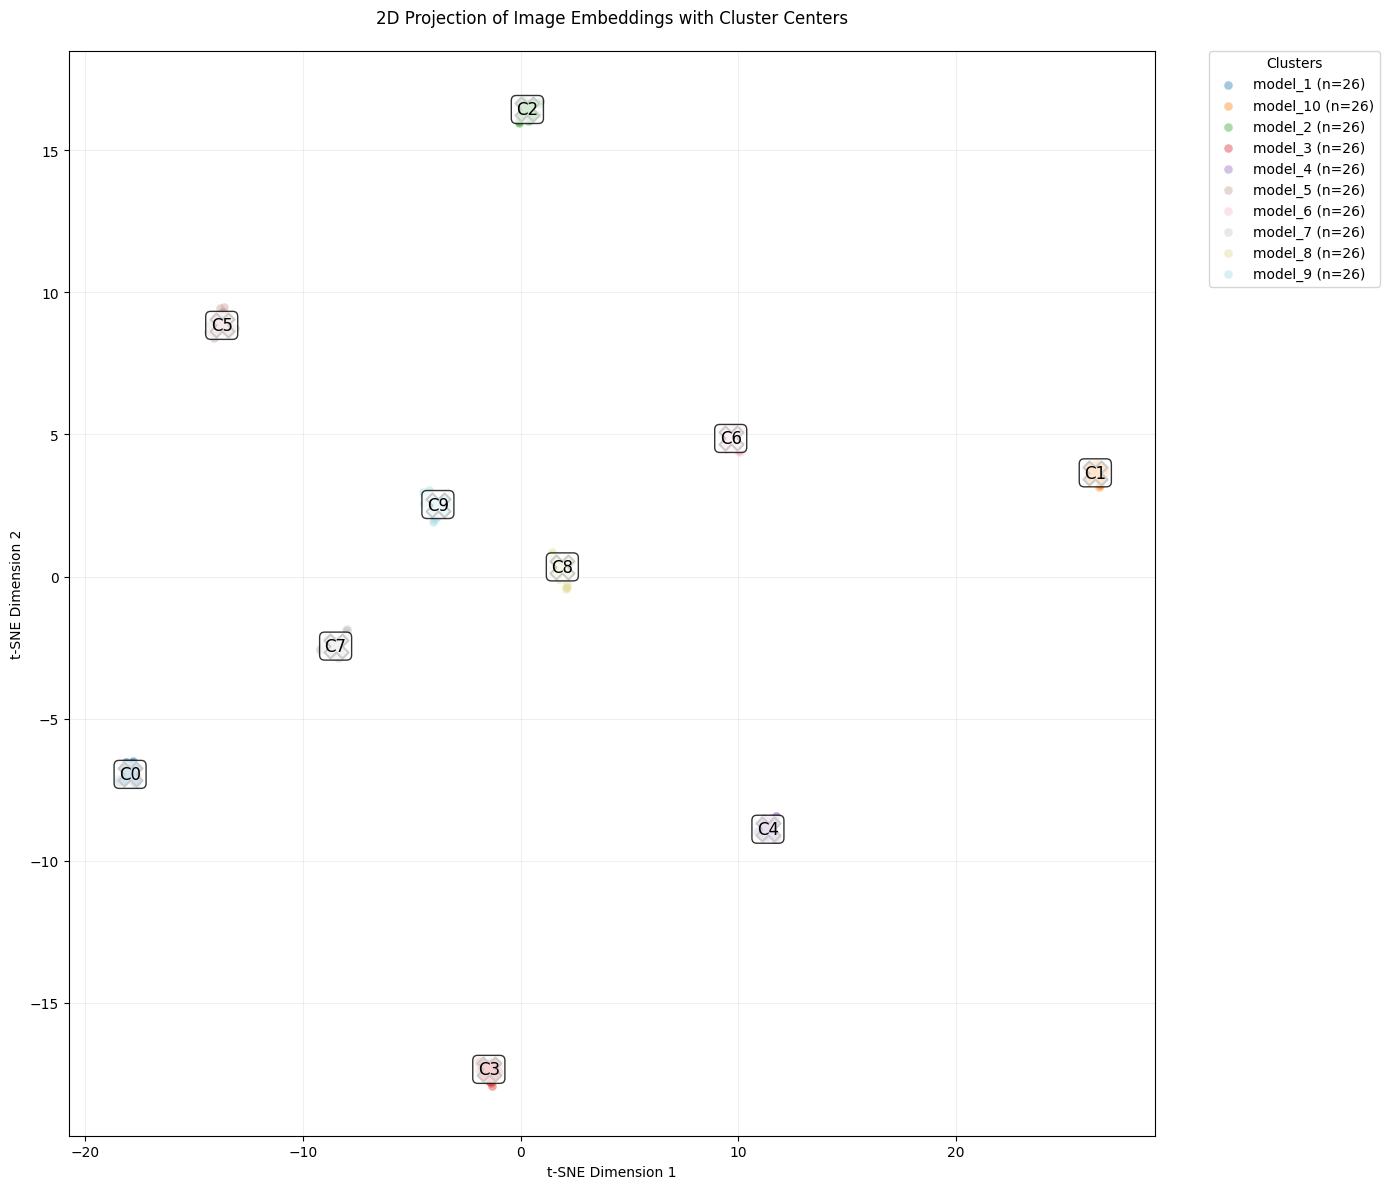

Расстояния между центрами кластеров:
[[ 0.        22.76521   20.811115  20.122972  19.8518    17.647358
  18.682089  15.745873  15.937663  17.41388  ]
 [22.76521    0.        20.601366  17.700912  17.649004  16.898268
  14.051152  14.465647  14.93407   15.138854 ]
 [20.811115  20.601366   0.        19.903341  18.186028  16.97618
  16.754387  15.7843275 13.945366  13.276469 ]
 [20.122972  17.700912  19.903341   0.        15.865877  16.522713
  14.014649  14.052874  13.025118  13.261834 ]
 [19.8518    17.649004  18.186028  15.865877   0.        14.241886
  13.543583  14.315598  12.790801  12.890199 ]
 [17.647358  16.898268  16.97618   16.522713  14.241886   0.
  14.90088   12.601126  12.146203  10.698158 ]
 [18.682089  14.051152  16.754387  14.014649  13.543583  14.90088
   0.        12.128842  10.191369  10.441382 ]
 [15.745873  14.465647  15.7843275 14.052874  14.315598  12.601126
  12.128842   0.        10.665203   9.230074 ]
 [15.937663  14.93407   13.945366  13.025118  12.790801  12

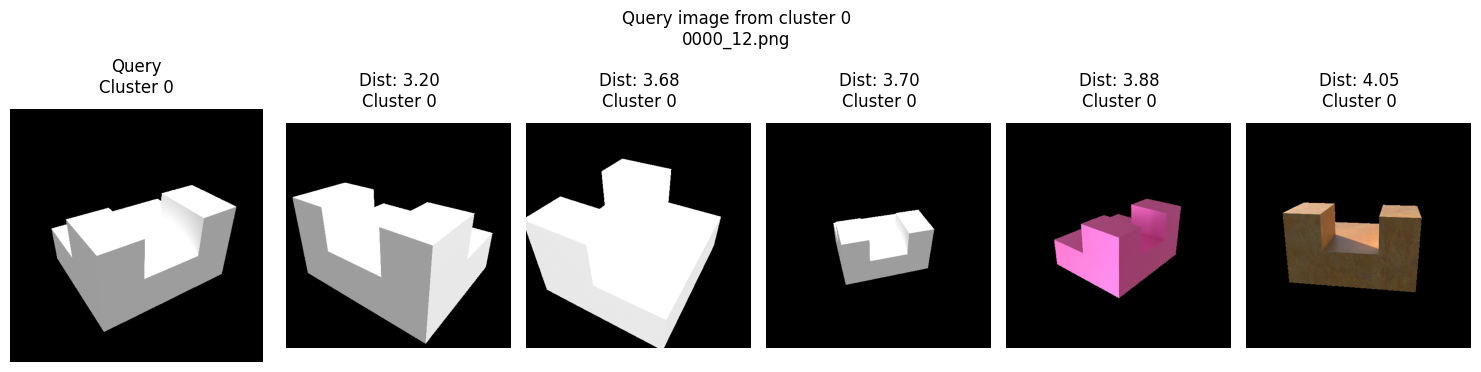

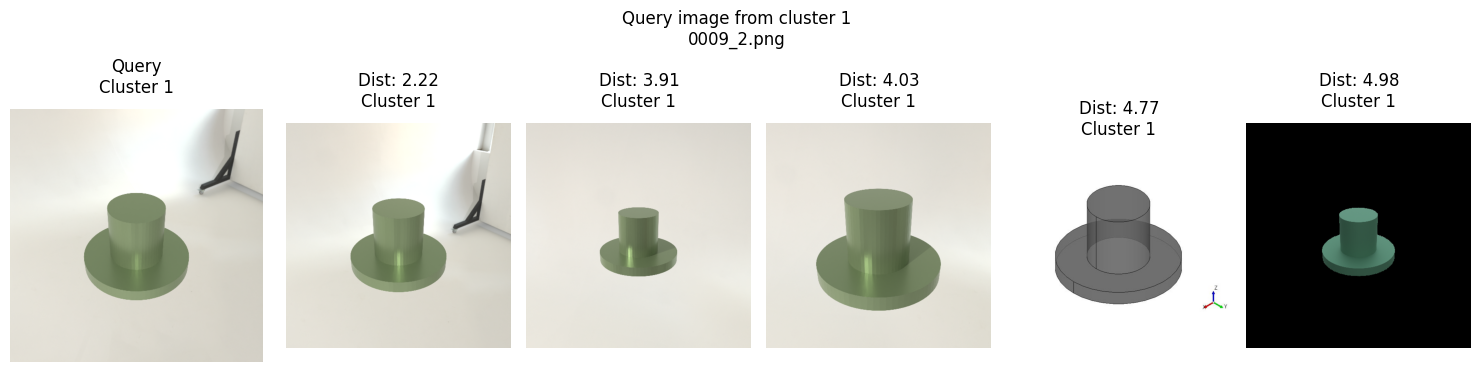

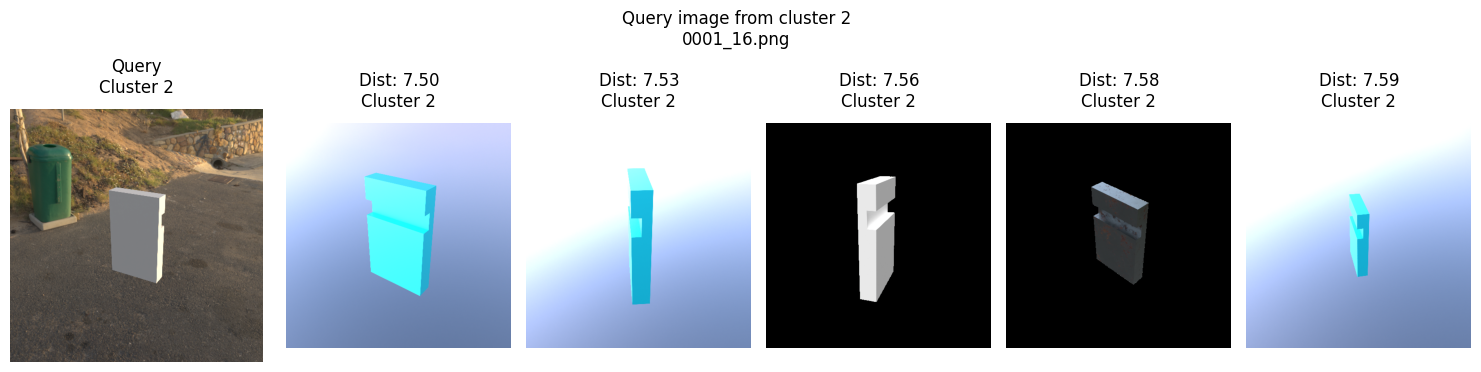

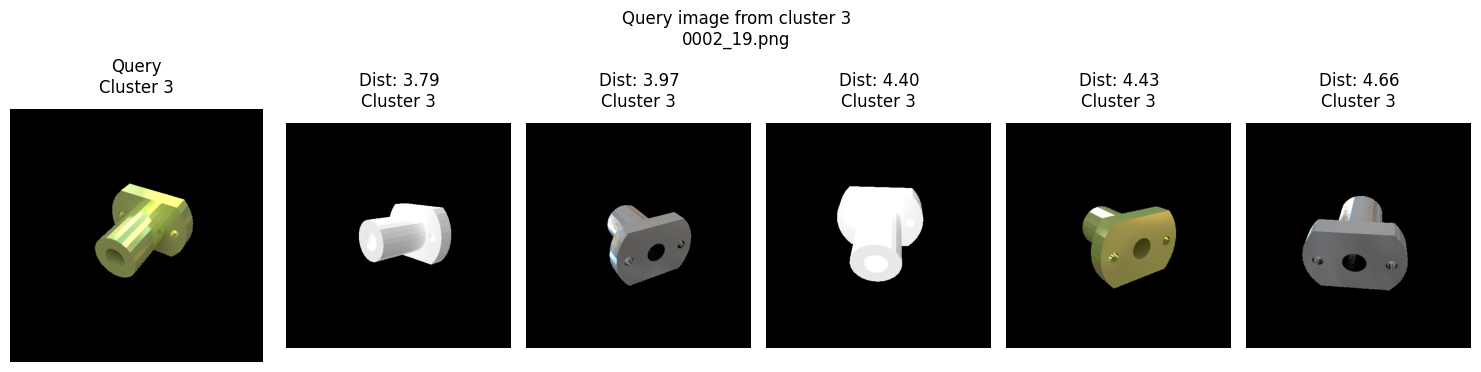

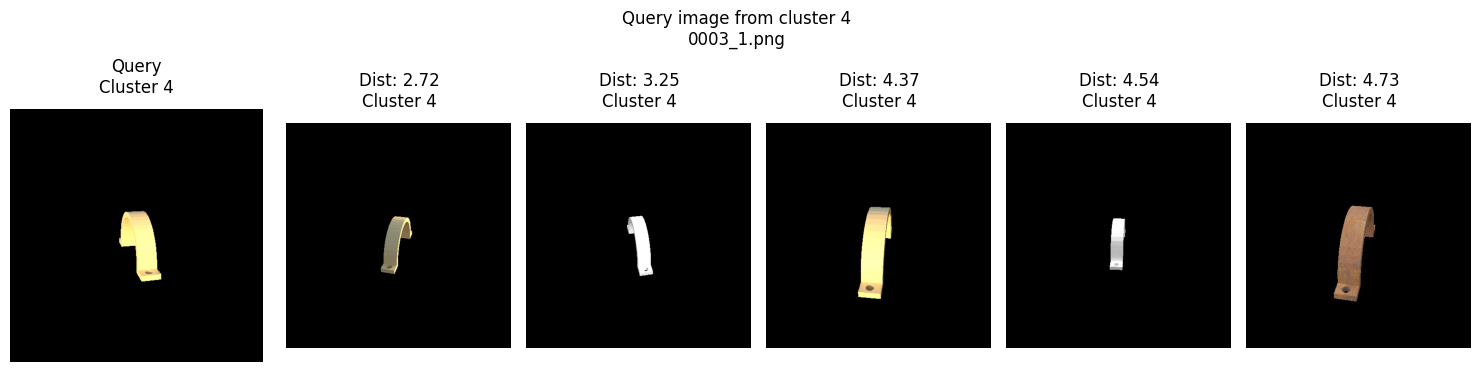

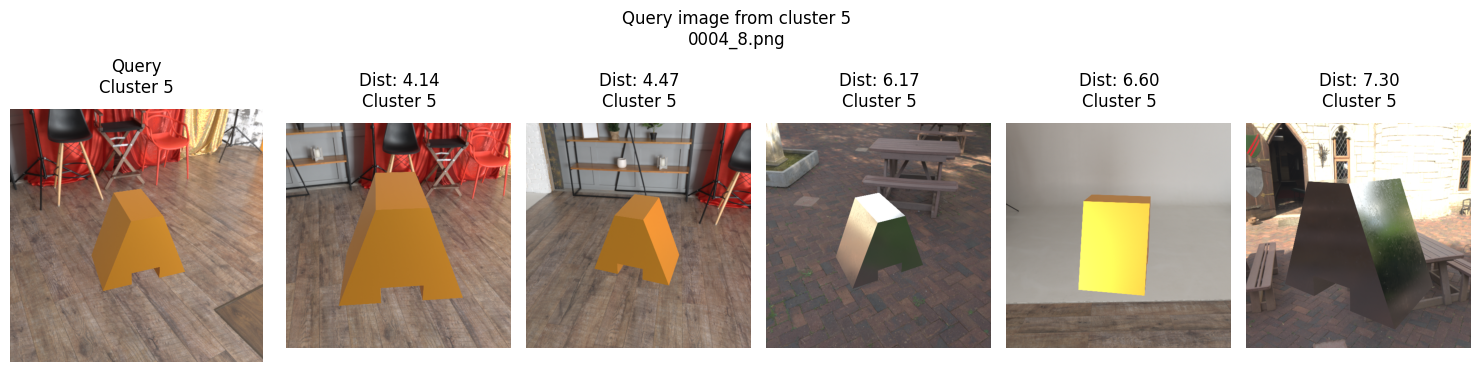

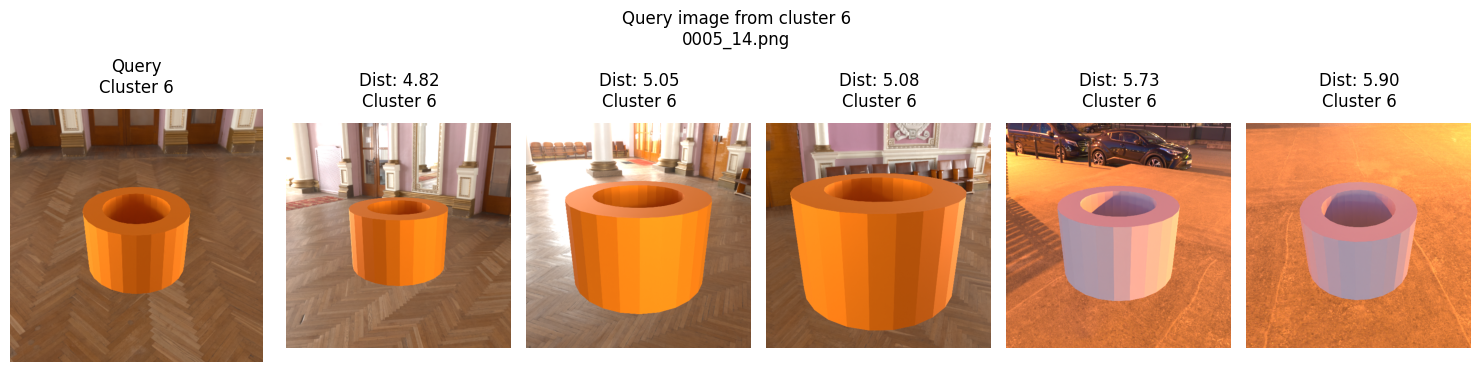

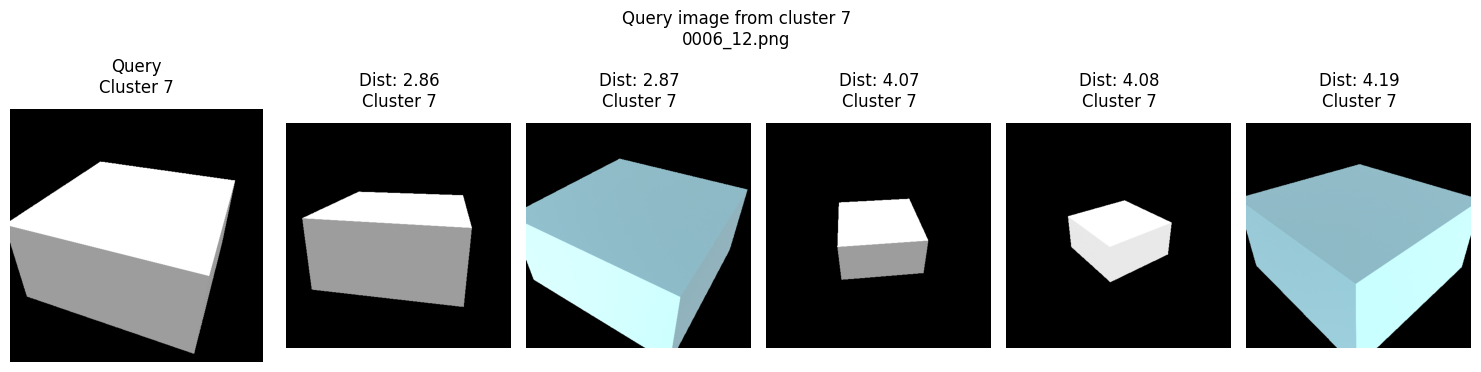

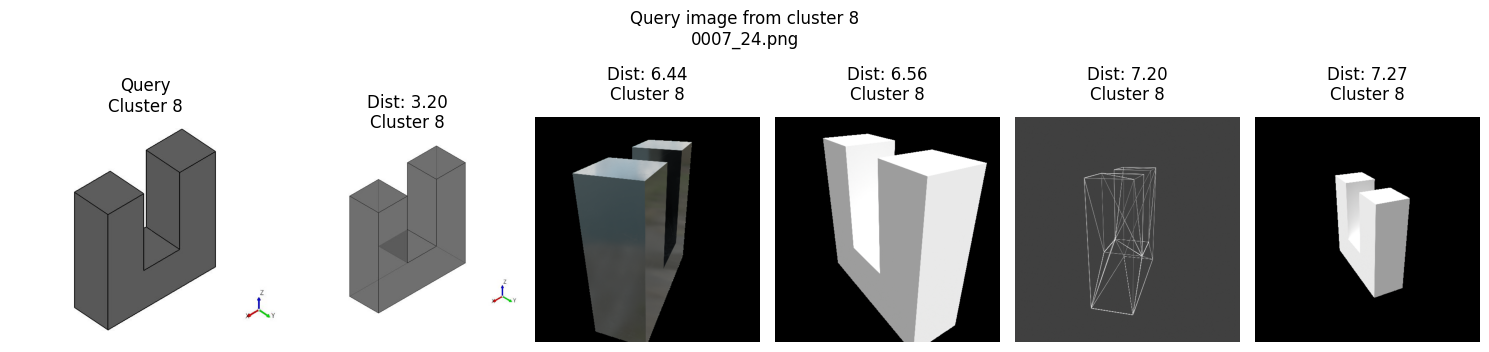

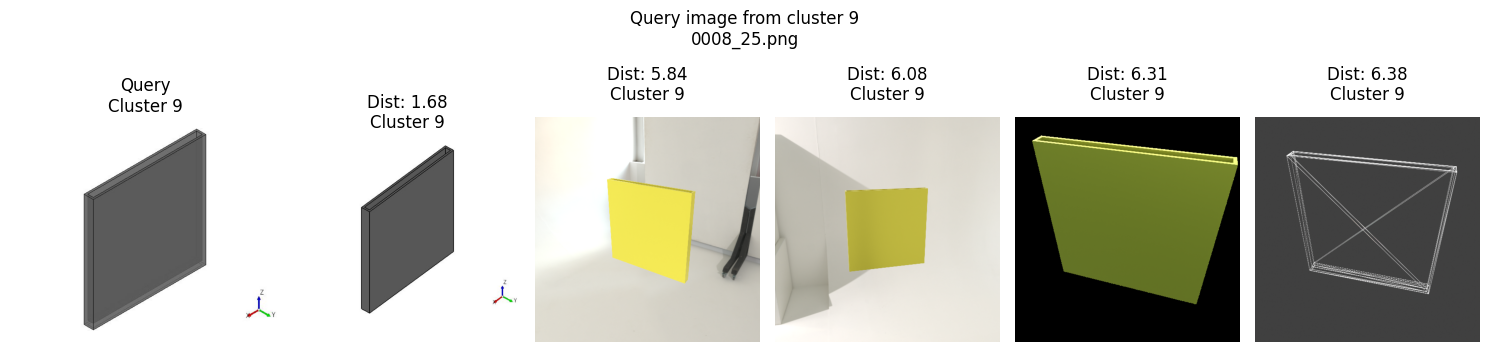

In [11]:
# Получаем список папок с моделями
model_folders = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) 
                if os.path.isdir(os.path.join(DATA_PATH, f))]
model_folders.sort()
print(f"Found {len(model_folders)} model folders")
    
# Инициализируем модель с актуальными весами
model = EmbeddingExtractor(EMBEDDING_SIZE).to(device)
model.eval()
    
# Извлекаем эмбеддинги для каждой папки
folder_embeddings = {}
for folder in model_folders:
    folder_embeddings[folder] = extract_folder_embeddings(model, folder)
    print(f"Processed folder {folder} with {len(folder_embeddings[folder])} images")
    
# Вычисляем центроиды
centroids = calculate_centroids(folder_embeddings)
    
# Гарантируем разделение кластеров
separated_centroids = ensure_cluster_separation(centroids, MIN_CLUSTER_DISTANCE)
    
# Обновляем эмбеддинги относительно новых центроидов
for folder in model_folders:
    delta = separated_centroids[folder] - centroids[folder]
    folder_embeddings[folder] += delta
    
# Собираем все эмбеддинги и метки
all_embeddings = []
all_labels = []
folder_names = []
for i, folder in enumerate(model_folders):
    all_embeddings.append(folder_embeddings[folder].numpy())
    all_labels.extend([i] * len(folder_embeddings[folder]))
    folder_names.append(os.path.basename(folder))
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.array(all_labels)
    
# Нормализуем эмбеддинги
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(all_embeddings)
    
# Визуализация с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(normalized_embeddings)
    
# Создаем график
plt.figure(figsize=(14, 12))
    
# Настройка цветовой палитры
colors = plt.cm.tab20(np.linspace(0, 1, len(model_folders)))
    
# Рисуем все точки с прозрачностью
for i, folder in enumerate(model_folders):
    # Выбираем точки текущего кластера
    mask = (all_labels == i)
    cluster_points = embeddings_2d[mask]
        
    # Рисуем точки элементов
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        color=colors[i],
        alpha=0.4,  # Полупрозрачные точки
        s=40,      # Размер точек
        edgecolors='w',
        linewidth=0.3,
        label=f'{os.path.basename(folder)} (n={len(cluster_points)})'
    )
        
    # Рисуем центроид
    centroid = cluster_points.mean(axis=0)
    plt.scatter(
        centroid[0],
        centroid[1],
        marker='X',
        color=colors[i],
        s=300,      # Большой размер для центроида
        edgecolor='black',
        linewidth=1.5,
        alpha=1.0   # Полностью непрозрачный
    )
        
    # Подпись центроида
    plt.text(
        centroid[0], 
        centroid[1], 
        f'C{i}',
        fontsize=12,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
    )
    
# Настройки графика
plt.title('2D Projection of Image Embeddings with Cluster Centers', pad=20)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(alpha=0.2)

# егенда с информацией о кластерах
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    title='Clusters'
)

plt.tight_layout()
plt.show()

# Вычисляем расстояния между кластерами
final_centroids = torch.stack(list(separated_centroids.values())).numpy()
distances = euclidean_distances(final_centroids)
print("Расстояния между центрами кластеров:")
print(distances)

# Сохраняем результаты
np.save('model_embeddings.npy', normalized_embeddings)
np.save('model_labels.npy', all_labels)
print("Results saved to disk")

# Визуализация ближайших соседей
print("\nVisualizing nearest neighbors...")

visualize_neighbors_improved(
    embeddings=normalized_embeddings,
    model_folders=model_folders,
    n_samples=15,
    k_neighbors=5
)



In [12]:
# Сохраняем модель и scaler для будущего использования
torch.save(model.state_dict(), 'embedding_model.pth')
import joblib
joblib.dump(scaler, 'scaler.pkl')

# Сохраняем информацию о текущих центроидах
np.save('cluster_centroids.npy', final_centroids)
np.save('folder_names.npy', np.array(folder_names))

print("Model, scaler and cluster data saved")

Model, scaler and cluster data saved


In [25]:
def load_images_from_folder(folder):
    """Загрузка изображений с улучшенной обработкой ошибок и проверкой уникальности"""
    images = []
    valid_extensions = ('.png', '.jpg', '.jpeg')
    
    if not os.path.exists(folder):
        raise ValueError(f"Папка {folder} не существует")
    
    for filename in sorted(os.listdir(folder)):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')
                    img_tensor = transform(img)
                    images.append((img_tensor, img_path))  # Сохраняем и тензор, и путь
            except Exception as e:
                print(f'Ошибка загрузки {img_path}: {str(e)}')
    
    if not images:
        raise ValueError(f"В папке {folder} нет валидных изображений")
        
    return images  # Возвращаем список кортежей (тензор, путь)

In [26]:
def check_unique_images(embeddings, paths, threshold=0.9):
    """Проверяет, что изображения действительно уникальны"""
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Вычисляем попарную схожесть
    sim_matrix = cosine_similarity(embeddings)
    np.fill_diagonal(sim_matrix, 0)  # Игнорируем сравнение с самим собой
    
    # Находим дубликаты
    duplicates = np.where(sim_matrix > threshold)
    duplicate_pairs = [(paths[i], paths[j]) for i, j in zip(*duplicates)]
    
    if duplicate_pairs:
        print("Найдены потенциальные дубликаты:")
        for pair in duplicate_pairs:
            print(f"{pair[0]} ~ {pair[1]}")
        return False
    return True

In [27]:
def add_new_clusters(new_folders, min_distance=MIN_CLUSTER_DISTANCE):
    """Улучшенная версия с проверкой уникальности"""
    # 1. Загрузка существующих данных
    try:
        old_embeddings = np.load('model_embeddings.npy')
        old_labels = np.load('model_labels.npy')
        old_folder_names = np.load('folder_names.npy').tolist()
        old_centroids = np.load('cluster_centroids.npy')
        scaler = joblib.load('scaler.pkl')
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None, None, None

    # 2. Инициализация модели
    model = EmbeddingExtractor(EMBEDDING_SIZE).to(device)
    model.load_state_dict(torch.load('embedding_model.pth'))
    model.eval()

    # 3. Обработка новых папок
    new_embeddings_list = []
    new_paths_list = []
    new_folder_names = []
    
    for folder in new_folders:
        try:
            # Загрузка изображений с путями
            images_data = load_images_from_folder(folder)
            if not images_data:
                continue
                
            images, paths = zip(*images_data)
            images_tensor = torch.stack(images).to(device)
            
            # Извлечение эмбеддингов
            with torch.no_grad():
                embeddings = model(images_tensor).cpu().numpy()
            
            # Проверка уникальности внутри папки
            if not check_unique_images(embeddings, paths):
                print(f"В папке {folder} найдены дубликаты! Пропускаем.")
                continue
                
            # Проверка расстояний до других кластеров
            centroid = embeddings.mean(axis=0)
            if len(old_centroids) > 0:
                dists = euclidean_distances([centroid], old_centroids)[0]
                min_dist = dists.min()
                
                if min_dist < min_distance:
                    closest_idx = np.argmin(dists)
                    print(f"Ошибка: Папка '{os.path.basename(folder)}' слишком близка к '{old_folder_names[closest_idx]}' (расстояние: {min_dist:.2f})")
                    continue

            new_embeddings_list.append(embeddings)
            new_paths_list.extend(paths)
            new_folder_names.append(os.path.basename(folder))
            print(f"Добавлена папка {folder} с {len(embeddings)} уникальными изображениями")
            
        except Exception as e:
            print(f"Ошибка обработки {folder}: {str(e)}")
            continue

    if not new_embeddings_list:
        print("Новые кластеры не добавлены")
        return old_embeddings, old_labels, old_folder_names

    # 4. Объединение данных
    try:
        new_labels = [len(old_folder_names) + i for i, emb in enumerate(new_embeddings_list) for _ in range(len(emb))]
        updated_embeddings = np.vstack([old_embeddings] + new_embeddings_list)
        updated_labels = np.hstack([old_labels] + new_labels)
        updated_folder_names = old_folder_names + new_folder_names
        
        # 5. Обновление scaler и нормализация
        scaler.fit(updated_embeddings)
        normalized_embeddings = scaler.transform(updated_embeddings)
        
        # 6. Сохранение
        np.save('model_embeddings.npy', normalized_embeddings)
        np.save('model_labels.npy', updated_labels)
        np.save('folder_names.npy', np.array(updated_folder_names))
        joblib.dump(scaler, 'scaler.pkl')
        
        print(f"Успешно! Добавлено {len(new_embeddings_list)} новых кластеров")
        return normalized_embeddings, updated_labels, updated_folder_names

    except Exception as e:
        print(f"Ошибка объединения: {str(e)}")
        return old_embeddings, old_labels, old_folder_names

In [15]:
def visualize_all_clusters(embeddings, labels, folder_names):
    """
    Безопасная визуализация всех кластеров с проверкой размеров
    """
    # Проверка соответствия размеров
    if len(embeddings) != len(labels):
        print(f"Error: mismatch in sizes - embeddings: {len(embeddings)}, labels: {len(labels)}")
        return
    
    # t-SNE преобразование
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    try:
        embeddings_2d = tsne.fit_transform(embeddings)
    except Exception as e:
        print(f"Error in t-SNE: {e}")
        return
    
    # Подготовка цветов
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    
    # Визуализация
    plt.figure(figsize=(16, 12))
    
    for i, label in enumerate(unique_labels):
        mask = (labels == label)
        if not np.any(mask):
            continue
            
        # Безопасный доступ к данным
        try:
            plt.scatter(
                embeddings_2d[mask, 0],
                embeddings_2d[mask, 1],
                color=colors[i],
                alpha=0.6,
                s=40,
                label=f'{folder_names[label]} (n={np.sum(mask)})'
            )
        except Exception as e:
            print(f"Error plotting cluster {label}: {e}")
            continue
    
    plt.legend(bbox_to_anchor=(1.05, 1), fontsize=8)
    plt.title(f'Cluster Visualization (Total clusters: {len(unique_labels)})', pad=20)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

In [28]:
# Перед вызовом add_new_clusters добавьте:
print("Проверка новых папок:")
for folder in new_folders:
    if not os.path.exists(folder):
        print(f"Ошибка: Папка {folder} не существует!")
    else:
        img_count = len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"Папка {folder} содержит {img_count} изображений")

# Только потом вызывайте:
embeddings, labels, folder_names = add_new_clusters(new_folders)

Проверка новых папок:
Папка images_test/model_11 содержит 26 изображений
Папка images_test/model_12 содержит 26 изображений
Найдены потенциальные дубликаты:
images_test/model_11\g0000_0.png ~ images_test/model_11\g0000_6.png
images_test/model_11\g0000_1.png ~ images_test/model_11\g0000_19.png
images_test/model_11\g0000_1.png ~ images_test/model_11\g0000_7.png
images_test/model_11\g0000_11.png ~ images_test/model_11\g0000_17.png
images_test/model_11\g0000_11.png ~ images_test/model_11\g0000_23.png
images_test/model_11\g0000_13.png ~ images_test/model_11\g0000_18.png
images_test/model_11\g0000_13.png ~ images_test/model_11\g0000_19.png
images_test/model_11\g0000_13.png ~ images_test/model_11\g0000_7.png
images_test/model_11\g0000_14.png ~ images_test/model_11\g0000_8.png
images_test/model_11\g0000_15.png ~ images_test/model_11\g0000_21.png
images_test/model_11\g0000_15.png ~ images_test/model_11\g0000_3.png
images_test/model_11\g0000_15.png ~ images_test/model_11\g0000_9.png
images_test/

Найдены потенциальные дубликаты:
images_test/model_11\g0000_0.png ~ images_test/model_11\g0000_6.png
images_test/model_11\g0000_1.png ~ images_test/model_11\g0000_19.png
images_test/model_11\g0000_1.png ~ images_test/model_11\g0000_7.png
images_test/model_11\g0000_11.png ~ images_test/model_11\g0000_17.png
images_test/model_11\g0000_11.png ~ images_test/model_11\g0000_23.png
images_test/model_11\g0000_13.png ~ images_test/model_11\g0000_18.png
images_test/model_11\g0000_13.png ~ images_test/model_11\g0000_19.png
images_test/model_11\g0000_13.png ~ images_test/model_11\g0000_7.png
images_test/model_11\g0000_14.png ~ images_test/model_11\g0000_8.png
images_test/model_11\g0000_15.png ~ images_test/model_11\g0000_21.png
images_test/model_11\g0000_15.png ~ images_test/model_11\g0000_3.png
images_test/model_11\g0000_15.png ~ images_test/model_11\g0000_9.png
images_test/model_11\g0000_17.png ~ images_test/model_11\g0000_11.png
images_test/model_11\g0000_17.png ~ images_test/model_11\g0000_23.

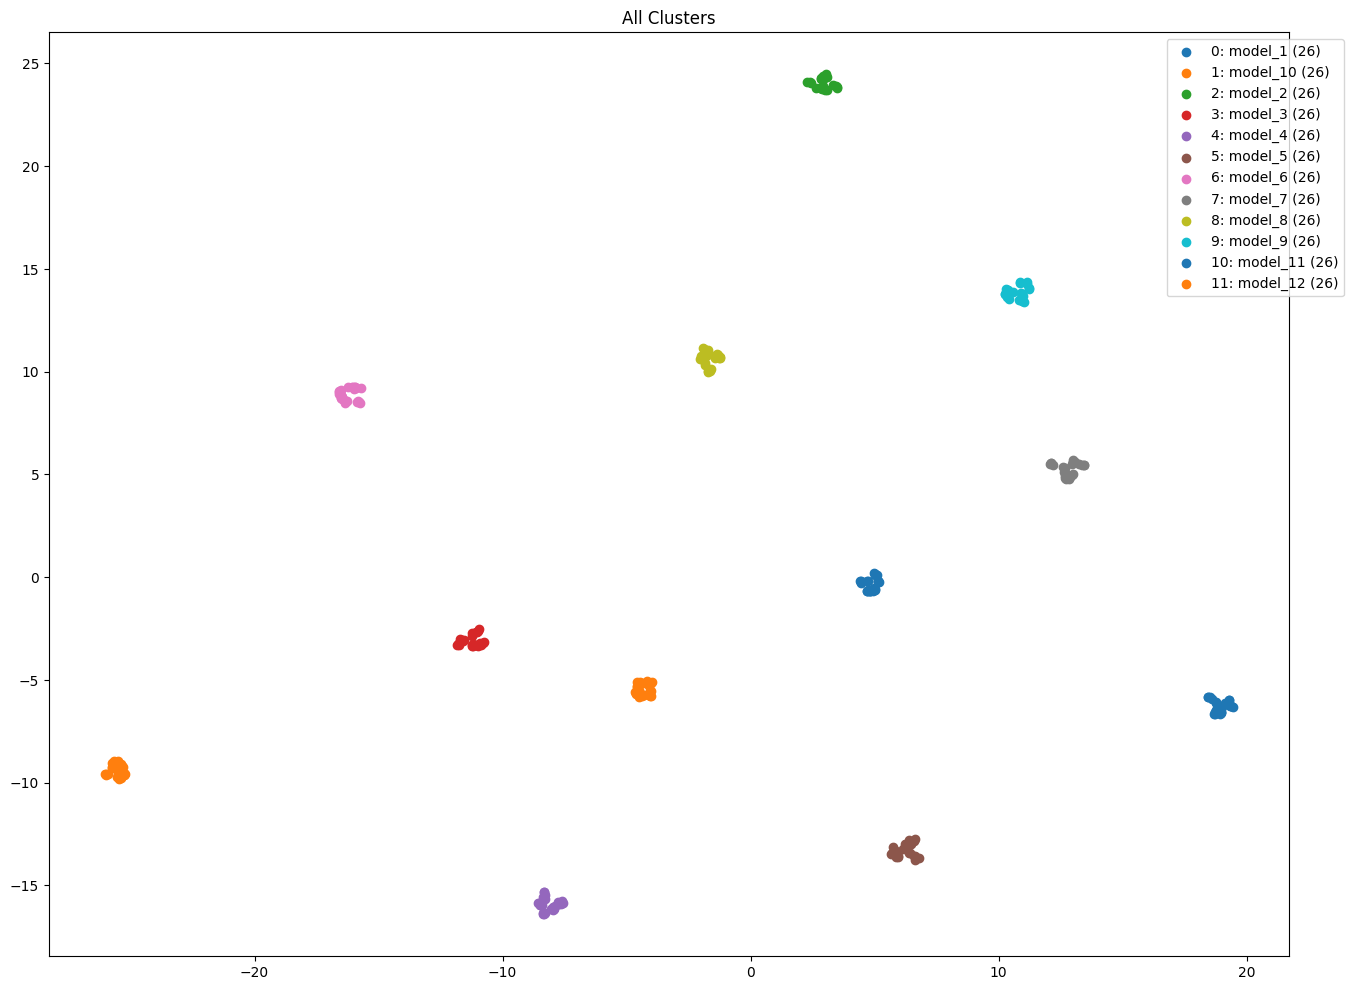

In [29]:
# 1. Добавление новых кластеров
new_folders = ['images_test/model_11', 'images_test/model_12'] 
embeddings, labels, folder_names = add_new_clusters(new_folders)

# 2. Проверка результатов
if embeddings is not None:
    print("\nCurrent clusters:")
    for i, name in enumerate(folder_names):
        print(f"{i}: {name} ({np.sum(labels == i)} images)")
    
    # 3. Визуализация
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(16, 12))
    for i in range(len(folder_names)):
        mask = labels == i
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                    label=f'{i}: {folder_names[i]} ({np.sum(mask)})')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title('All Clusters')
    plt.show()

In [17]:
def enforce_cluster_separation(embeddings, labels, min_distance=5.0):
    """
    Принудительно раздвигает кластеры, чтобы соблюдалось минимальное расстояние
    между их центроидами. Возвращает скорректированные эмбеддинги.
    """
    # Вычисляем текущие центроиды
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == label].mean(axis=0) for label in unique_labels])
    
    # Вычисляем попарные расстояния
    distances = euclidean_distances(centroids)
    np.fill_diagonal(distances, np.inf)  # Игнорируем расстояние до самого себя
    
    # Находим слишком близкие пары кластеров
    too_close = distances < min_distance
    needs_adjustment = np.any(too_close)
    
    if not needs_adjustment:
        print("Все кластеры уже удовлетворяют условиям минимального расстояния")
        return embeddings
    
    print("Найдены слишком близкие кластеры. Провожу коррекцию...")
    
    # Оптимизируем позиции центроидов
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            if distances[i,j] < min_distance:
                # Вычисляем вектор направления между центроидами
                direction = centroids[i] - centroids[j]
                direction = direction / np.linalg.norm(direction)
                
                # Вычисляем необходимый сдвиг
                move = (min_distance - distances[i,j]) / 2
                
                # Сдвигаем центроиды
                centroids[i] += direction * move
                centroids[j] -= direction * move
    
    # Корректируем все эмбеддинги относительно новых центроидов
    adjusted_embeddings = np.zeros_like(embeddings)
    for label in unique_labels:
        old_centroid = embeddings[labels == label].mean(axis=0)
        new_centroid = centroids[label]
        delta = new_centroid - old_centroid
        adjusted_embeddings[labels == label] = embeddings[labels == label] + delta
    
    # Обновляем сохраненные данные
    np.save('model_embeddings.npy', adjusted_embeddings)
    np.save('cluster_centroids.npy', centroids)
    
    # Проверяем новые расстояния
    new_distances = euclidean_distances(centroids)
    np.fill_diagonal(new_distances, np.inf)
    print(f"Минимальное расстояние после коррекции: {new_distances.min():.2f}")
    
    return adjusted_embeddings

Все кластеры уже удовлетворяют условиям минимального расстояния


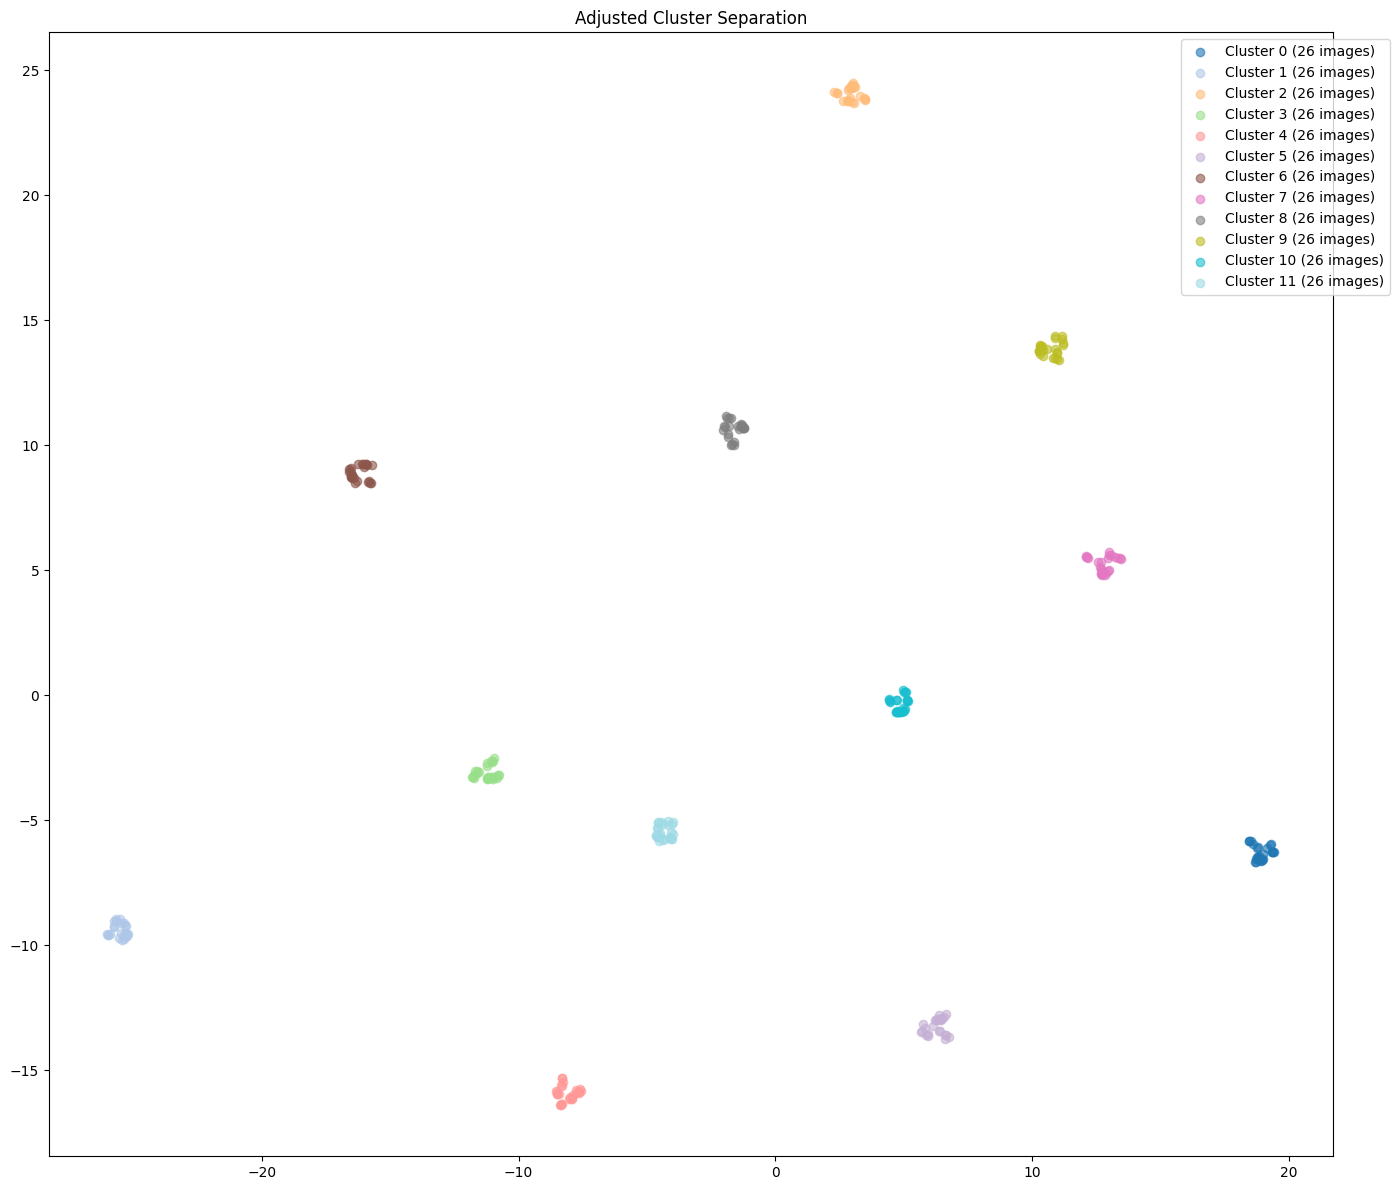

In [30]:
# Применяем коррекцию к текущим данным
current_embeddings = np.load('model_embeddings.npy')
current_labels = np.load('model_labels.npy')

adjusted_embeddings = enforce_cluster_separation(
    embeddings=current_embeddings,
    labels=current_labels,
    min_distance=15.0  # Можно увеличить для большего разделения
)

# Визуализируем результат
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
adjusted_2d = tsne.fit_transform(adjusted_embeddings)

plt.figure(figsize=(14, 12))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(current_labels))))

for label in np.unique(current_labels):
    mask = current_labels == label
    plt.scatter(
        adjusted_2d[mask, 0], adjusted_2d[mask, 1],
        color=colors[label],
        alpha=0.6,
        label=f'Cluster {label} ({np.sum(mask)} images)'
    )

plt.title('Adjusted Cluster Separation')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Данные успешно сохранены:
- Эмбеддинги: (312, 256)
- Метки: (312,)
- Центроиды: (12, 256)
Данные успешно загружены:
- Дата коррекции: 2025-08-05 19:39:19
- Минимальное расстояние: 15.0
- Количество кластеров: 12
- Количество образцов: 312


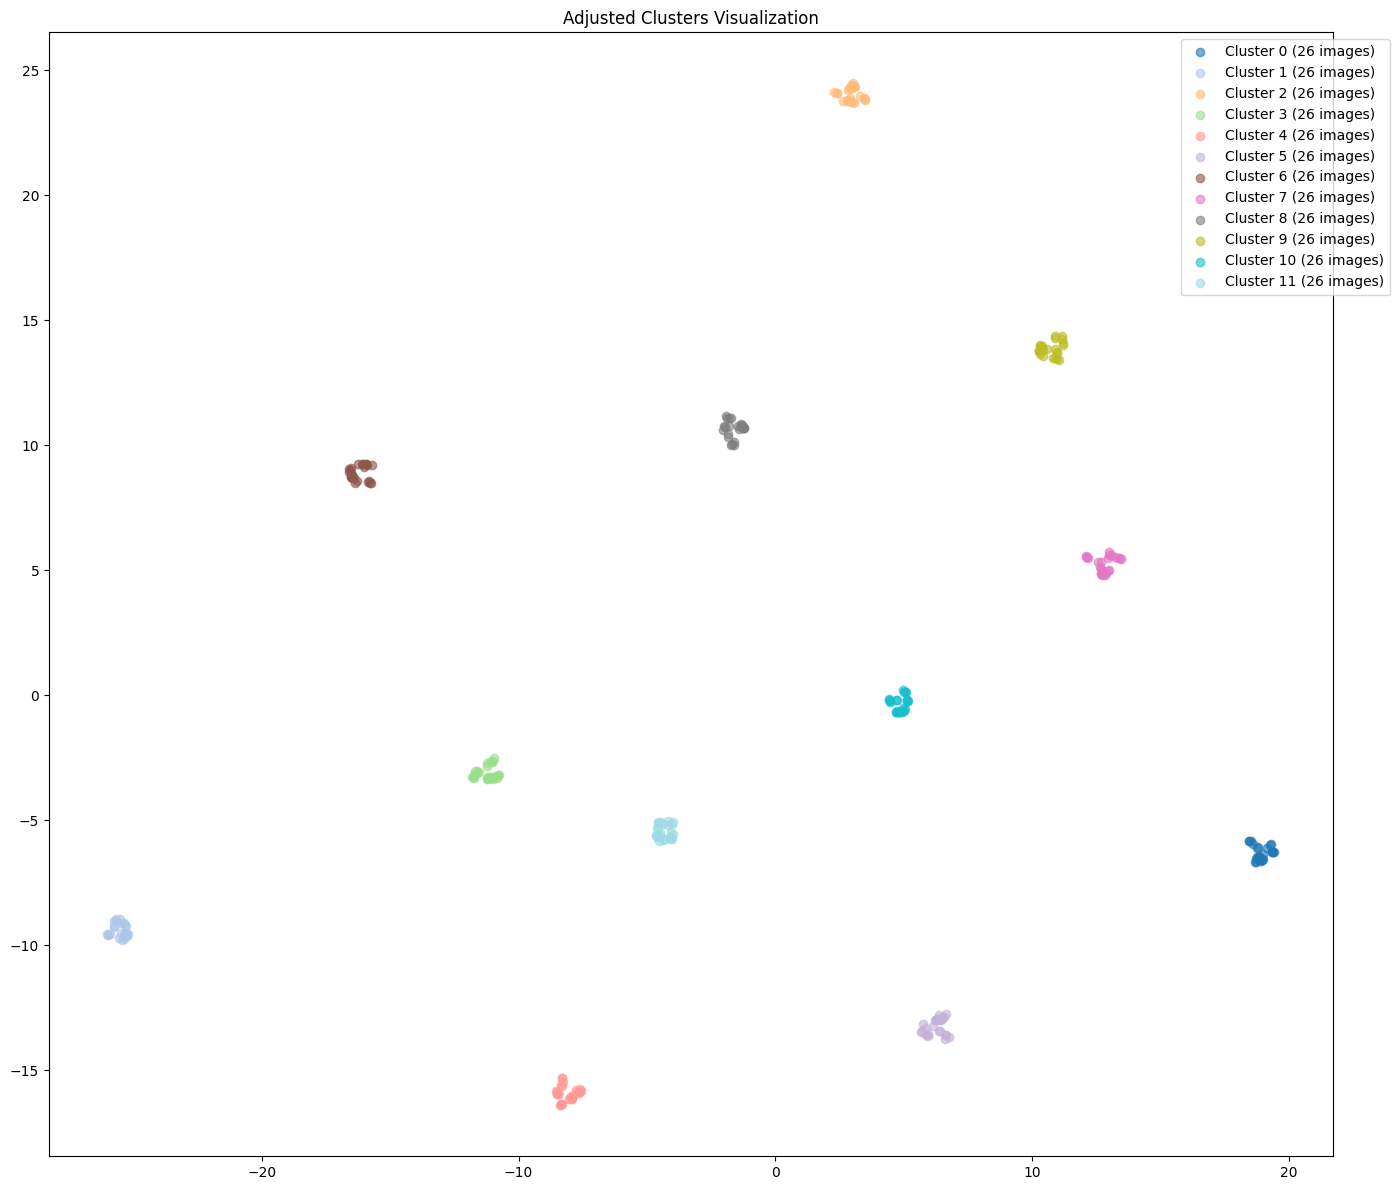

In [31]:
from datetime import datetime
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# 1. Блок сохранения обновленных данных (исправленный)
def save_adjusted_data(embeddings, labels, centroids=None, min_distance=15.0):
    """
    Сохраняет скорректированные эмбеддинги и связанные данные
    с добавленной проверкой ошибок и логированием
    """
    try:
        # Проверка входных данных
        if len(embeddings) != len(labels):
            raise ValueError("Размеры embeddings и labels не совпадают")
            
        if centroids is not None and len(centroids) != len(np.unique(labels)):
            raise ValueError("Количество центроидов не соответствует числу кластеров")
        
        # Сохраняем основные данные
        np.save('adjusted_embeddings.npy', embeddings)
        np.save('adjusted_labels.npy', labels)
        
        # Сохраняем центроиды, если они переданы
        if centroids is not None:
            np.save('adjusted_centroids.npy', centroids)
        
        # Логирование параметров коррекции
        adjustment_info = {
            'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'min_distance': min_distance,
            'num_clusters': len(np.unique(labels)),
            'num_samples': len(embeddings),
            'embedding_dim': embeddings.shape[1]
        }
        
        with open('adjustment_info.txt', 'w') as f:
            for key, value in adjustment_info.items():
                f.write(f"{key}: {value}\n")
        
        print("Данные успешно сохранены:")
        print(f"- Эмбеддинги: {embeddings.shape}")
        print(f"- Метки: {labels.shape}")
        if centroids is not None:
            print(f"- Центроиды: {centroids.shape}")
        
        return True
        
    except Exception as e:
        print(f"Ошибка при сохранении: {str(e)}")
        return False

# 2. Блок загрузки скорректированных данных (улучшенный)
def load_adjusted_data():
    """
    Загружает скорректированные данные с проверкой целостности
    Возвращает: (embeddings, labels, centroids, adjustment_info)
    """
    try:
        # Проверяем существование файлов
        if not os.path.exists('adjusted_embeddings.npy') or not os.path.exists('adjusted_labels.npy'):
            raise FileNotFoundError("Файлы с данными не найдены")
            
        # Загрузка данных
        embeddings = np.load('adjusted_embeddings.npy')
        labels = np.load('adjusted_labels.npy')
        
        # Загрузка центроидов (если есть)
        centroids = np.load('adjusted_centroids.npy') if os.path.exists('adjusted_centroids.npy') else None
        
        # Загрузка информации о коррекции
        adjustment_info = {}
        if os.path.exists('adjustment_info.txt'):
            with open('adjustment_info.txt', 'r') as f:
                for line in f:
                    key, value = line.strip().split(': ')
                    adjustment_info[key] = value
        
        # Проверка целостности
        if len(embeddings) != len(labels):
            raise ValueError("Несоответствие размеров embeddings и labels")
            
        if centroids is not None and len(centroids) != len(np.unique(labels)):
            raise ValueError("Несоответствие количества центроидов числу кластеров")
        
        print("Данные успешно загружены:")
        print(f"- Дата коррекции: {adjustment_info.get('date', 'неизвестно')}")
        print(f"- Минимальное расстояние: {adjustment_info.get('min_distance', 'неизвестно')}")
        print(f"- Количество кластеров: {len(np.unique(labels))}")
        print(f"- Количество образцов: {len(embeddings)}")
        
        return embeddings, labels, centroids, adjustment_info
        
    except Exception as e:
        print(f"Ошибка при загрузке: {str(e)}")
        return None, None, None, None

# 3. Пример использования после вашего кода:
# Применяем коррекцию к текущим данным
current_embeddings = np.load('model_embeddings.npy')
current_labels = np.load('model_labels.npy')
# Сохраняем результаты
save_success = save_adjusted_data(
    embeddings=adjusted_embeddings,
    labels=current_labels,
    centroids=np.load('cluster_centroids.npy'),
    min_distance=15.0
)
if save_success:
    # Загружаем и визуализируем сохраненные данные
    loaded_embeddings, loaded_labels, loaded_centroids, info = load_adjusted_data()
    
    if loaded_embeddings is not None:
        # Визуализация
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        embeddings_2d = tsne.fit_transform(loaded_embeddings)
        plt.figure(figsize=(14, 12))
        colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(loaded_labels))))
        for label in np.unique(loaded_labels):
            mask = loaded_labels == label
            plt.scatter(
                embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                color=colors[label],
                alpha=0.6,
                label=f'Cluster {label} ({np.sum(mask)} images)'
            )
        plt.title('Adjusted Clusters Visualization')
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

In [32]:
import numpy as np
import logging
from datetime import datetime
import os
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def validate_and_fix_data():
    """Функция для проверки и исправления данных"""
    try:
        # Загрузка данных
        embeddings = np.load('model_embeddings.npy')
        labels = np.load('model_labels.npy')
        folder_names = np.load('folder_names.npy')
        
        # Проверка размеров
        if len(embeddings) != len(labels):
            logger.error(f"Несоответствие размеров: embeddings {embeddings.shape}, labels {labels.shape}")
            
            # Находим правильный размер (минимальный из двух)
            min_length = min(len(embeddings), len(labels))
            
            # Обрезаем массивы до одинакового размера
            embeddings = embeddings[:min_length]
            labels = labels[:min_length]
            
            # Сохраняем исправленные данные
            np.save('model_embeddings.npy', embeddings)
            np.save('model_labels.npy', labels)
            
            logger.info(f"Данные исправлены. Новый размер: {len(embeddings)}")
        
        return embeddings, labels, folder_names
        
    except Exception as e:
        logger.error(f"Ошибка при проверке данных: {str(e)}")
        raise

def save_data(embeddings, labels, folder_names):
    """Безопасное сохранение данных с проверкой размеров"""
    assert len(embeddings) == len(labels), "Количество эмбеддингов и меток не совпадает"
    
    np.save('model_embeddings.npy', embeddings)
    np.save('model_labels.npy', labels)
    np.save('folder_names.npy', np.array(folder_names))
    
    logger.info(f"Данные сохранены. Размеры: embeddings {embeddings.shape}, labels {labels.shape}")

In [33]:
from datetime import datetime
import numpy as np
import os
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def visualize_new_clusters_neighbors(new_folder_indices, k_neighbors=5, figsize=(18, 4), samples_per_cluster=3):
    """
    Визуализирует случайные элементы из новых кластеров и их ближайших соседей.
    
    Args:
        new_folder_indices: список индексов новых кластеров (можно использовать отрицательные индексы)
        k_neighbors: количество отображаемых соседей
        figsize: размер фигуры для визуализации
        samples_per_cluster: количество случайных примеров из каждого кластера
    """
    try:
        # 1. Проверка и исправление данных
        logger.info("Проверка целостности данных...")
        embeddings, labels, folder_names = validate_and_fix_data()
        
        # Проверка согласованности данных
        if len(embeddings) != len(labels):
            raise ValueError(f"Несоответствие размеров: embeddings {embeddings.shape}, labels {labels.shape}")
        
        # 2. Валидация индексов
        valid_indices = []
        for idx in new_folder_indices:
            abs_idx = idx if idx >= 0 else len(folder_names) + idx
            if 0 <= abs_idx < len(folder_names):
                valid_indices.append(abs_idx)
            else:
                logger.warning(f"Недопустимый индекс кластера: {idx}")
        
        if not valid_indices:
            raise ValueError("Нет валидных индексов кластеров для визуализации")
        
        # 3. Загрузка изображений с кэшированием
        logger.info("Загрузка изображений...")
        image_cache = {}
        model_folders = [os.path.join(DATA_PATH, f) for f in folder_names]
        
        for folder in model_folders:
            if not os.path.exists(folder):
                logger.warning(f"Папка не существует: {folder}")
                continue
                
            for filename in sorted(os.listdir(folder)):
                if filename.endswith('.png'):
                    img_path = os.path.join(folder, filename)
                    try:
                        img = Image.open(img_path).convert('RGB')
                        image_cache[img_path] = img
                    except Exception as e:
                        logger.error(f"Ошибка загрузки {img_path}: {str(e)}")
        
        if not image_cache:
            raise ValueError("Не удалось загрузить ни одного изображения")
        
        # 4. Анализ и визуализация для каждого кластера
        for cluster_idx in valid_indices:
            try:
                cluster_name = folder_names[cluster_idx]
                logger.info(f"Анализ кластера {cluster_idx} ({cluster_name})...")
                
                # Проверка наличия точек в кластере
                cluster_mask = labels == cluster_idx
                if not np.any(cluster_mask):
                    logger.warning(f"Кластер {cluster_idx} пуст")
                    continue
                
                cluster_indices = np.where(cluster_mask)[0]
                cluster_size = len(cluster_indices)
                
                # Выбираем несколько случайных изображений из кластера
                if cluster_size < samples_per_cluster:
                    sample_indices = cluster_indices
                else:
                    sample_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=False)
                
                # Для каждого случайного изображения находим ближайших соседей
                for sample_idx in sample_indices:
                    # Вычисляем расстояния до всех точек (включая свой кластер)
                    distances = np.linalg.norm(embeddings - embeddings[sample_idx], axis=1)
                    
                    # Сортируем по расстоянию (исключая саму точку)
                    sorted_indices = np.argsort(distances)
                    sorted_indices = sorted_indices[sorted_indices != sample_idx]  # Исключаем саму точку
                    
                    # Берем k_neighbors ближайших (включая свой кластер)
                    neighbor_indices = sorted_indices[:k_neighbors]
                    
                    # 5. Визуализация
                    plt.figure(figsize=figsize)
                    plt.suptitle(
                        f"Анализ кластера {cluster_idx}: {cluster_name}\n"
                        f"Всего изображений: {cluster_size}, Дата: {datetime.now().strftime('%Y-%m-%d %H:%M')}",
                        y=1.05
                    )
                    
                    # Исходное изображение
                    ax = plt.subplot(1, k_neighbors + 1, 1)
                    img_path = list(image_cache.keys())[sample_idx % len(image_cache)]
                    ax.imshow(image_cache[img_path])
                    ax.set_title(f"Случайное изображение\nиз кластера {cluster_idx}", pad=12)
                    ax.axis('off')
                    
                    # Ближайшие соседи (включая свой кластер)
                    for i, neighbor_idx in enumerate(neighbor_indices, start=2):
                        ax = plt.subplot(1, k_neighbors + 1, i)
                        img_path = list(image_cache.keys())[neighbor_idx % len(image_cache)]
                        ax.imshow(image_cache[img_path])
                        
                        neighbor_cluster = labels[neighbor_idx]
                        dist = distances[neighbor_idx]
                        
                        ax.set_title(
                            f"Сосед {i-1}\n"
                            f"Кластер: {neighbor_cluster}\n"
                            f"Расст.: {dist:.2f}\n"
                            f"{folder_names[neighbor_cluster]}",
                            pad=12
                        )
                        ax.axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                
            except Exception as e:
                logger.error(f"Ошибка при обработке кластера {cluster_idx}: {str(e)}")
                continue
                
    except Exception as e:
        logger.error(f"Ошибка визуализации: {str(e)}")
        raise



In [34]:
# Проверка и исправление данных перед использованием
embeddings, labels, folder_names = validate_and_fix_data()
print(f"Размеры после проверки: embeddings {embeddings.shape}, labels {labels.shape}")

Размеры после проверки: embeddings (312, 256), labels (312,)


INFO:__main__:Проверка целостности данных...
INFO:__main__:Загрузка изображений...
INFO:__main__:Анализ кластера 0 (model_1)...


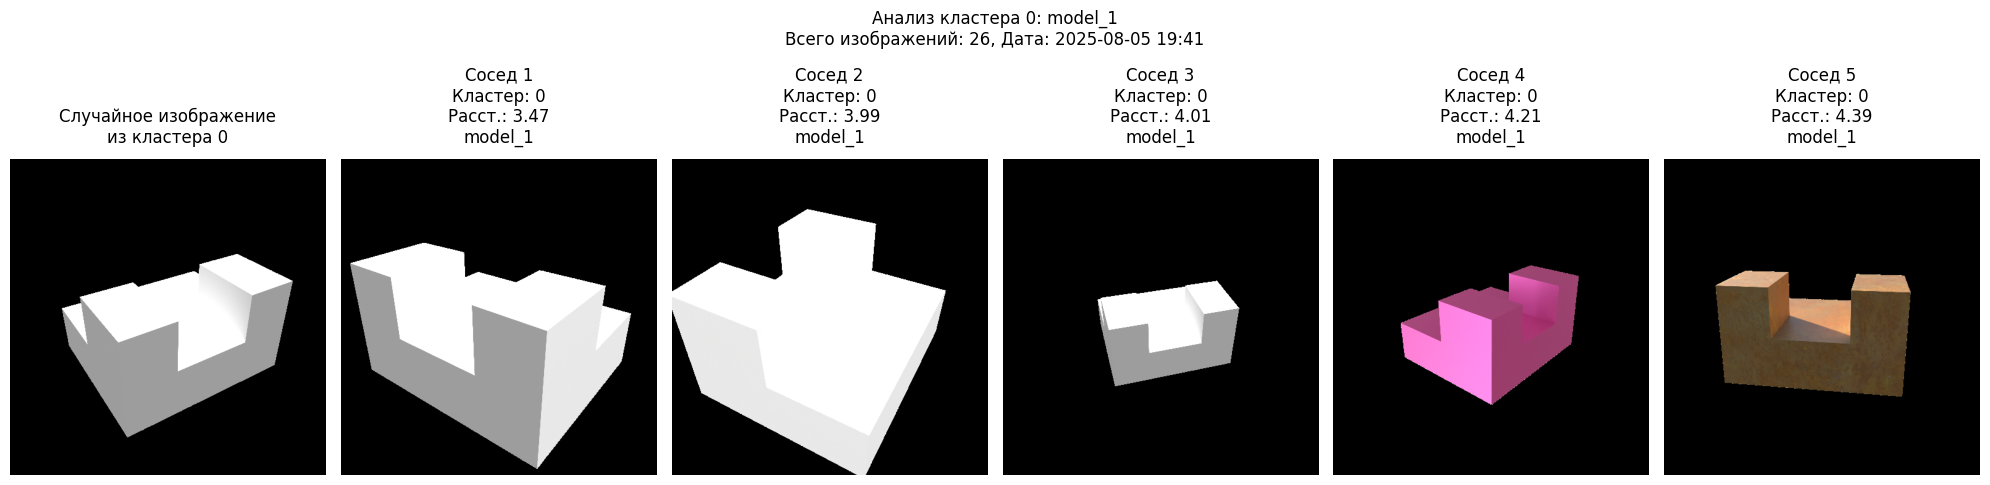

INFO:__main__:Анализ кластера 1 (model_10)...


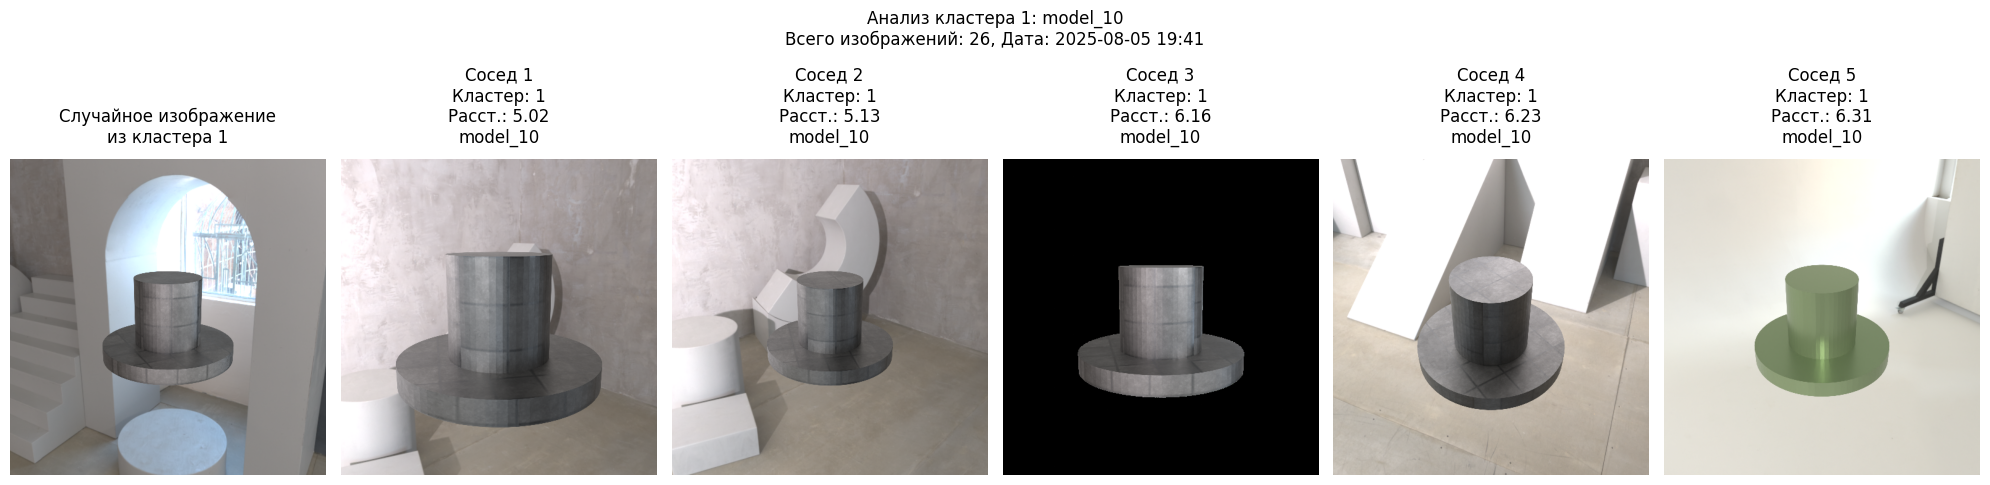

INFO:__main__:Анализ кластера 2 (model_2)...


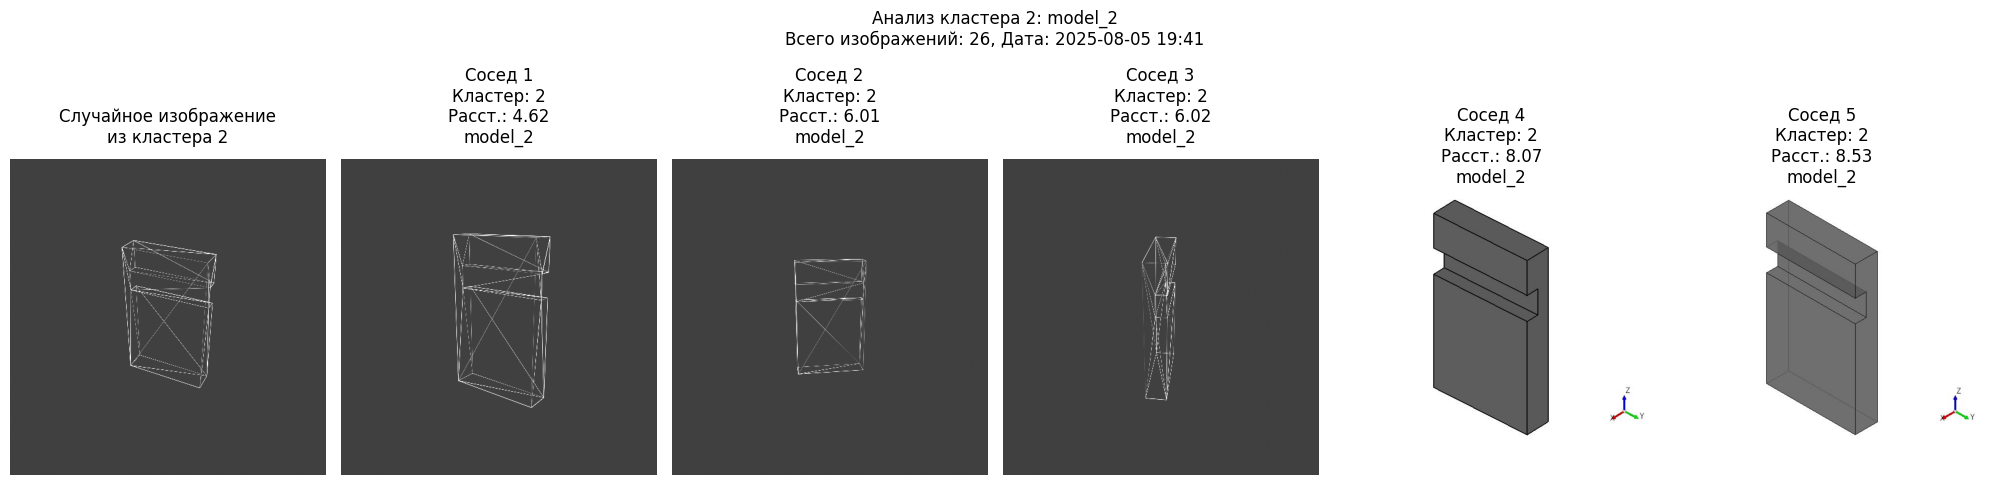

INFO:__main__:Анализ кластера 3 (model_3)...


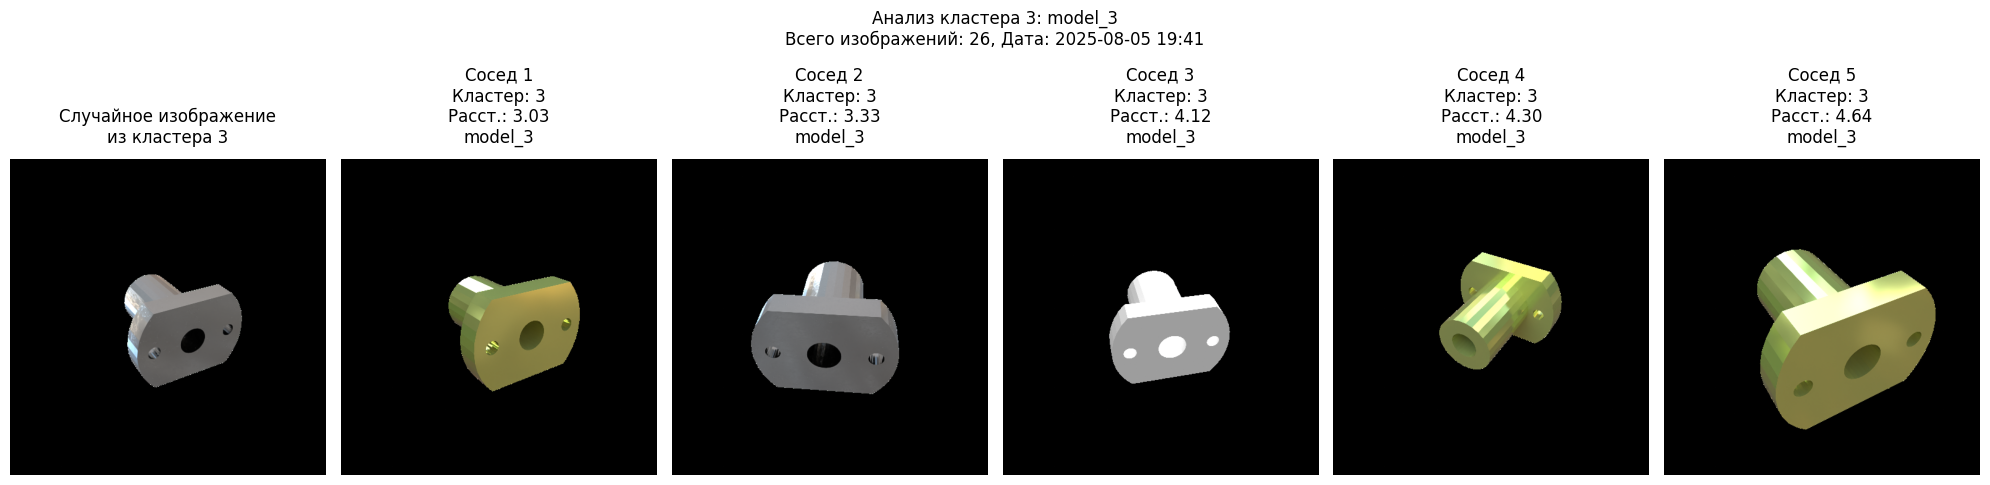

INFO:__main__:Анализ кластера 4 (model_4)...


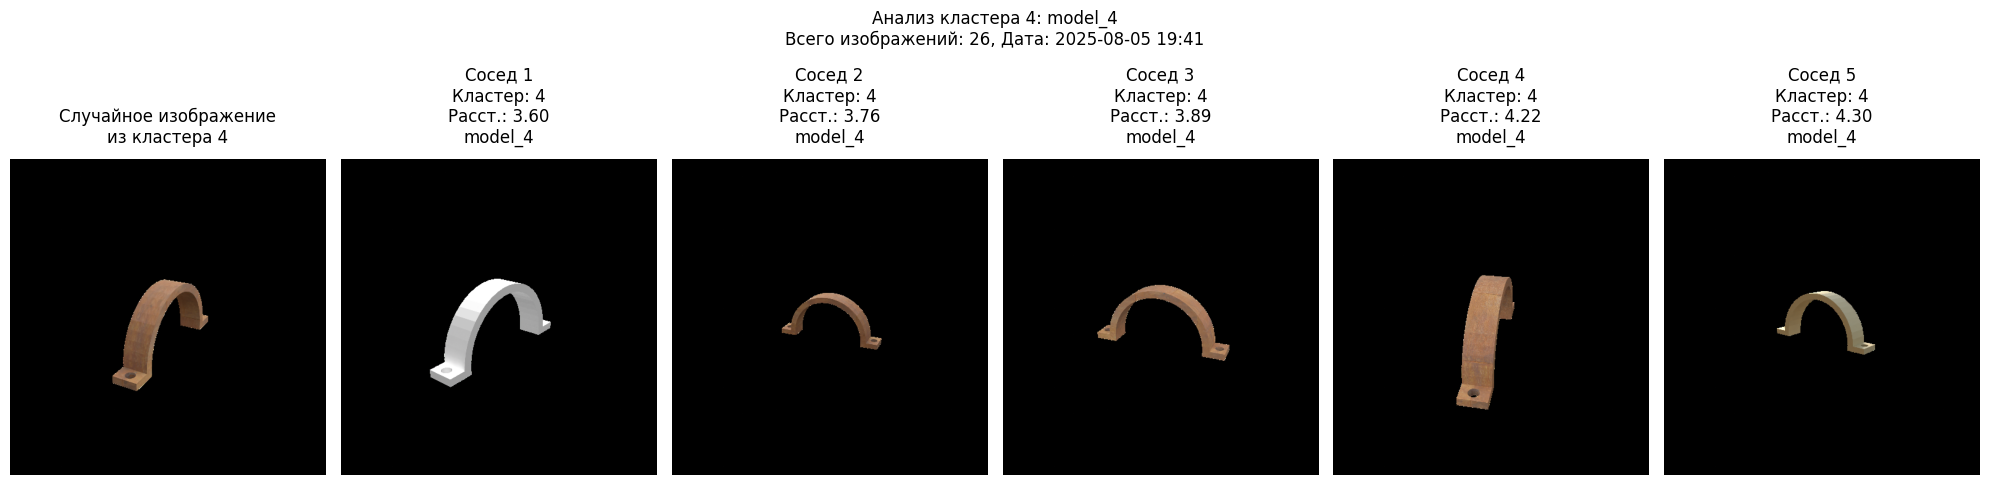

INFO:__main__:Анализ кластера 5 (model_5)...


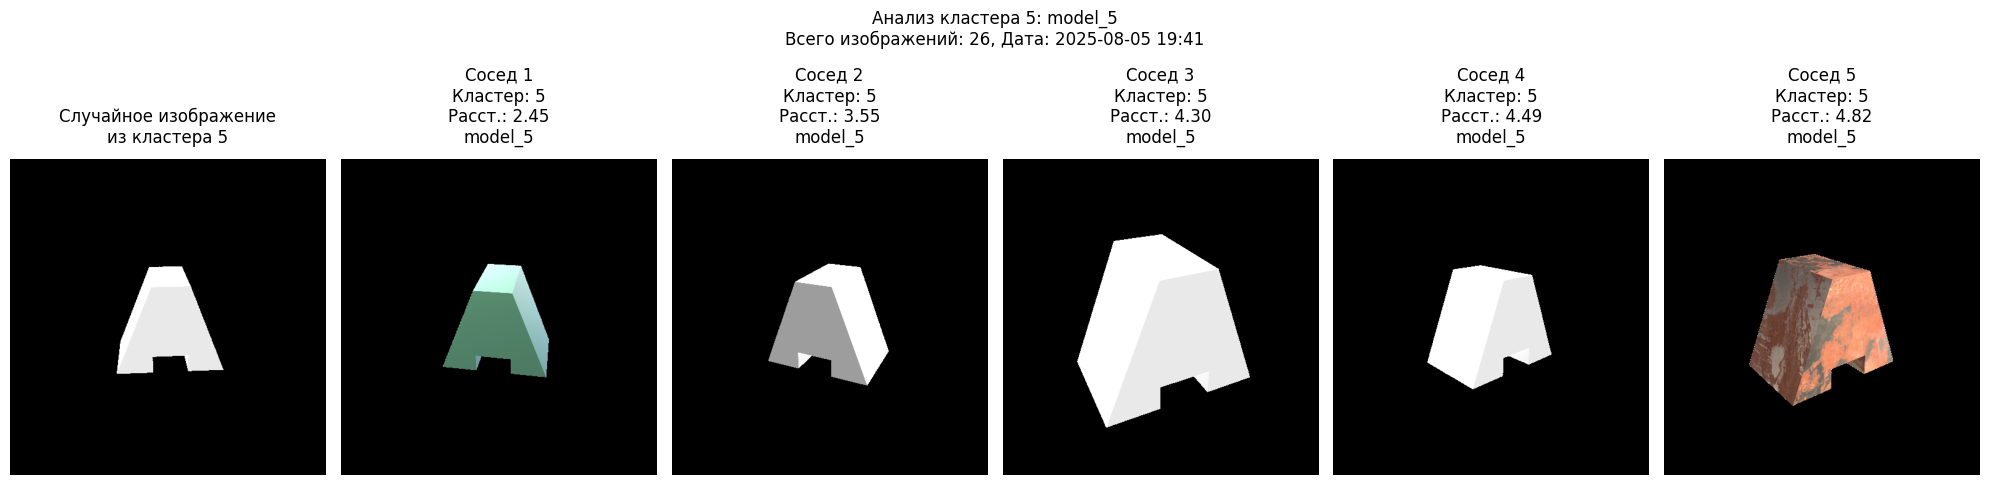

INFO:__main__:Анализ кластера 6 (model_6)...


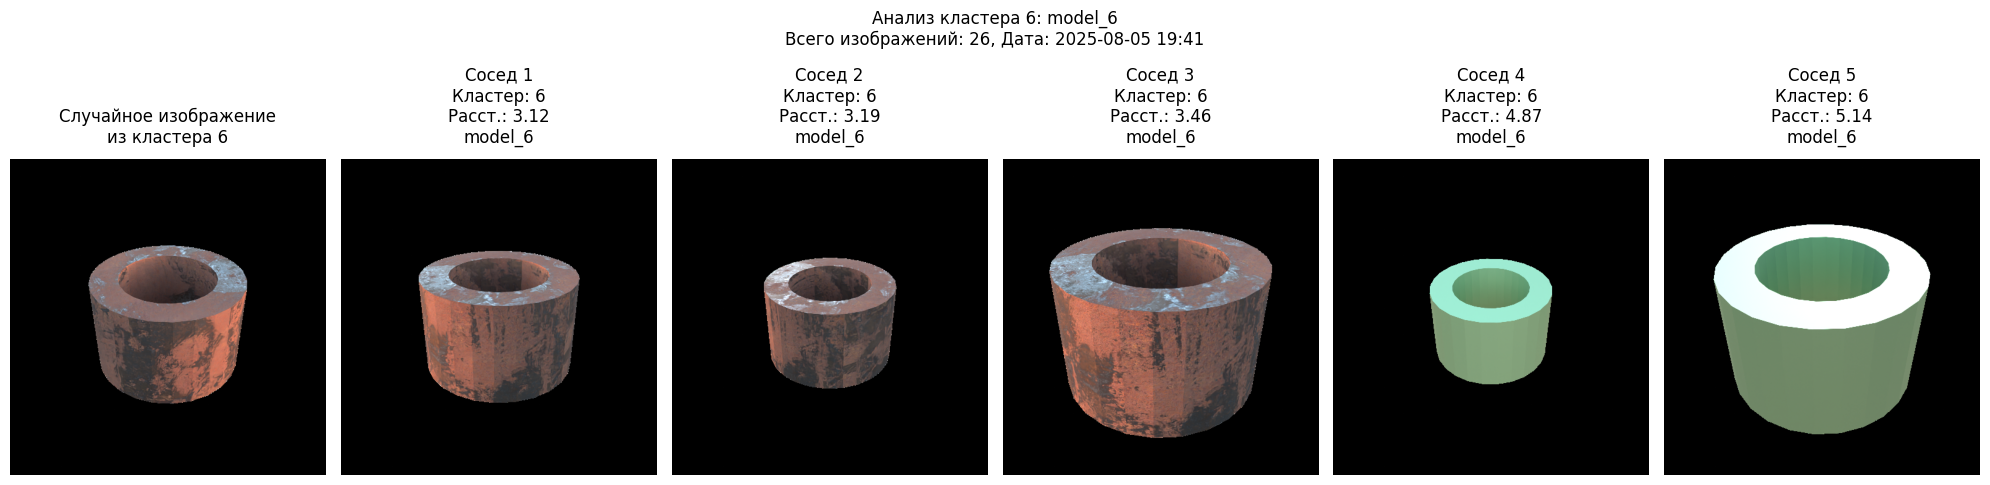

INFO:__main__:Анализ кластера 7 (model_7)...


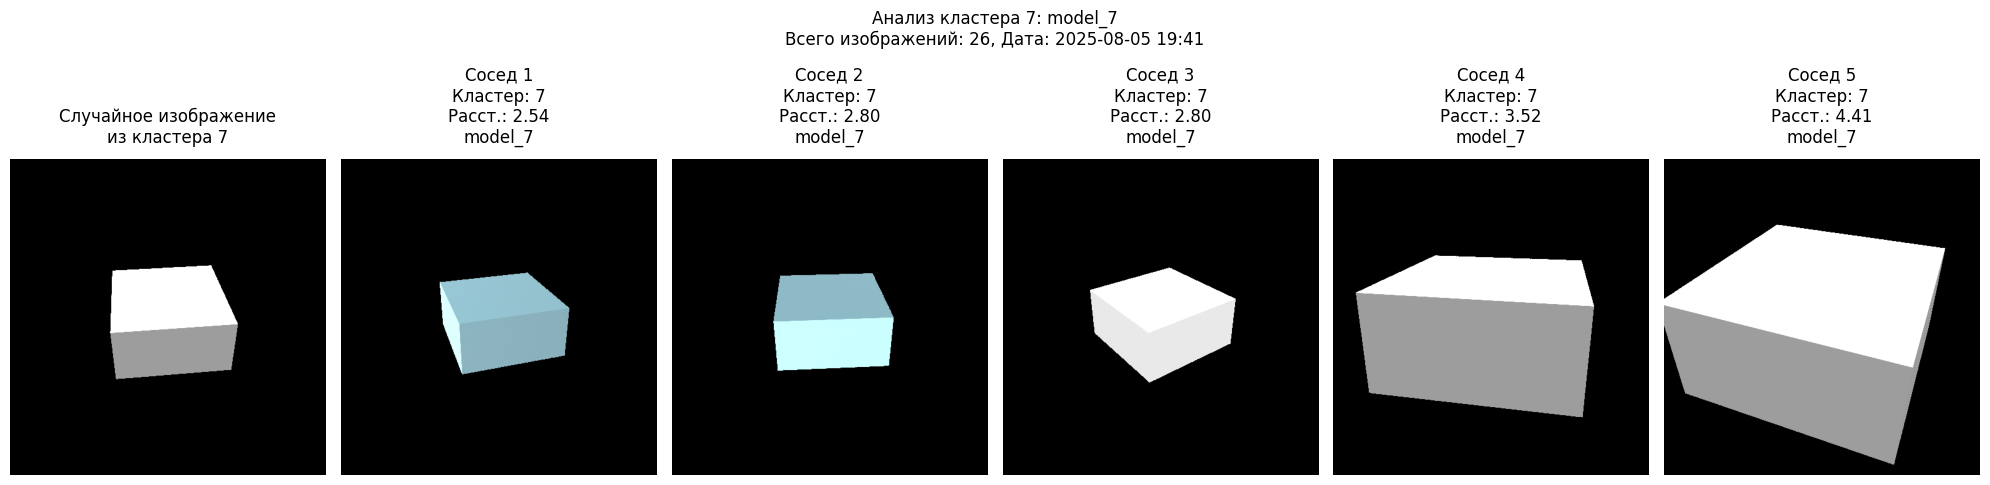

INFO:__main__:Анализ кластера 8 (model_8)...


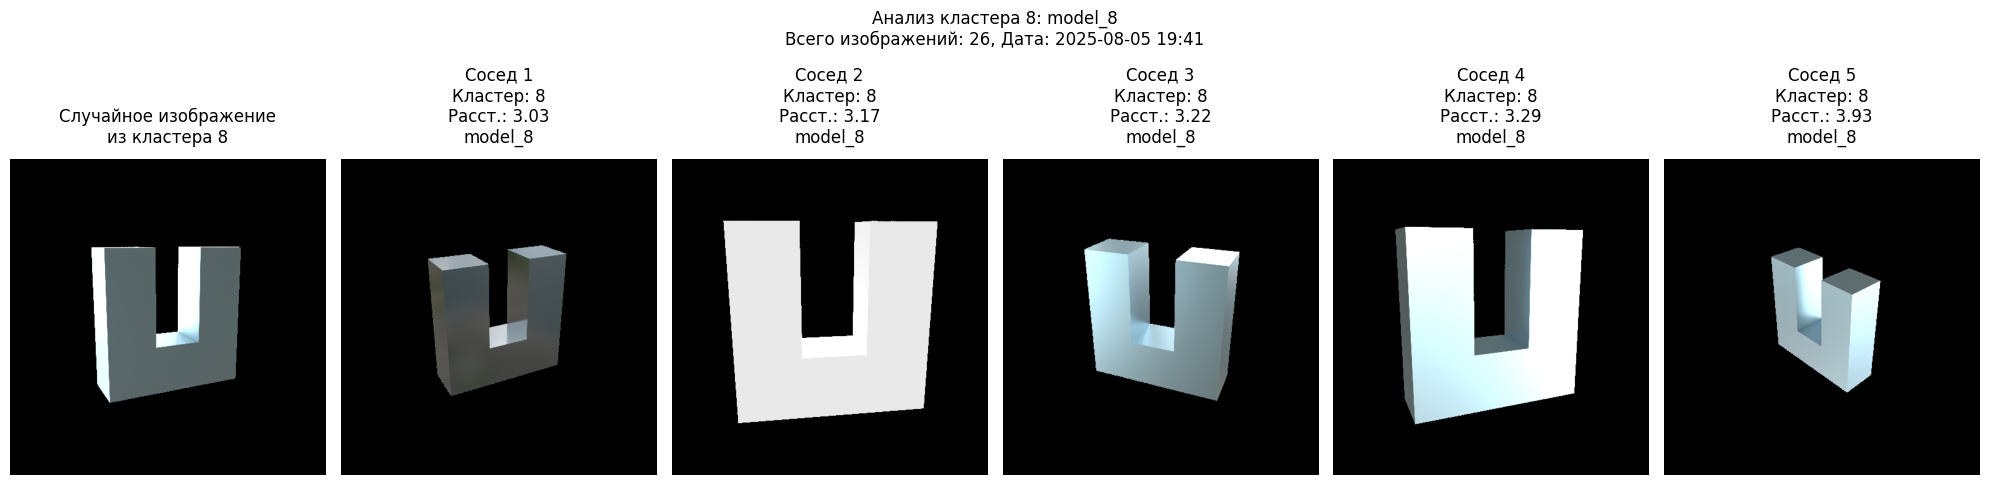

INFO:__main__:Анализ кластера 9 (model_9)...


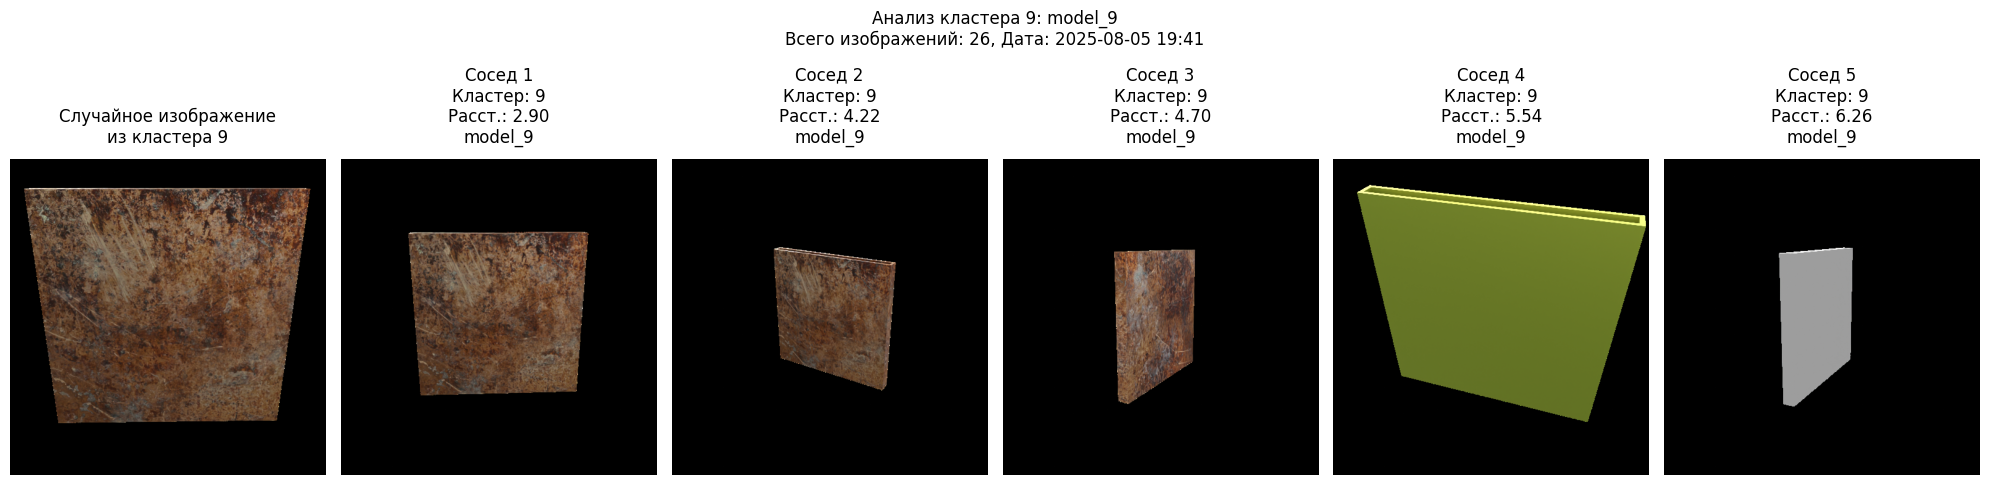

INFO:__main__:Анализ кластера 10 (model_11)...


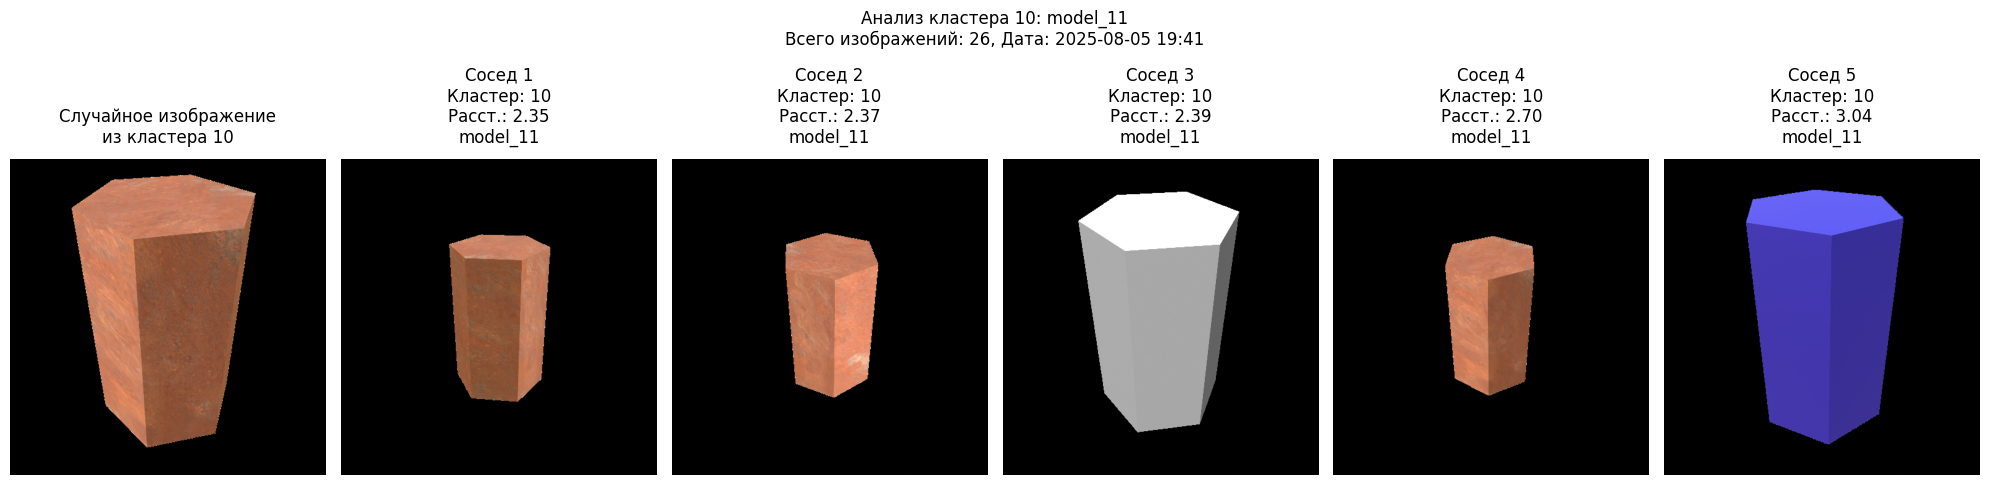

INFO:__main__:Анализ кластера 11 (model_12)...


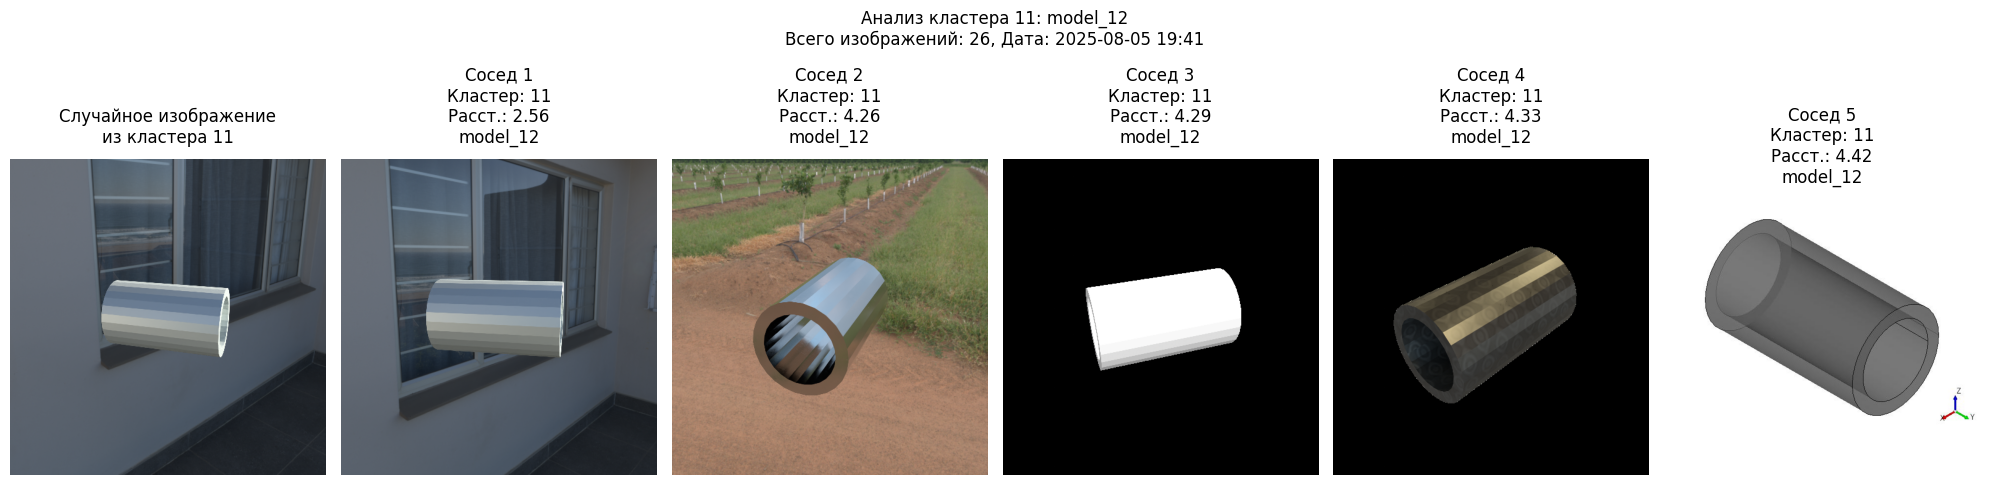

In [37]:
try:
    visualize_new_clusters_neighbors(
        new_folder_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],  # Последние два кластера
        k_neighbors=5,
        figsize=(20, 5),
        samples_per_cluster=1  # По 3 случайных примера из каждого кластера
    )
except Exception as e:
    logger.error(f"Ошибка при визуализации: {str(e)}")

INFO:__main__:Проверка целостности данных...
INFO:__main__:Загрузка изображений...
INFO:__main__:Анализ кластера 11 (model_12)...


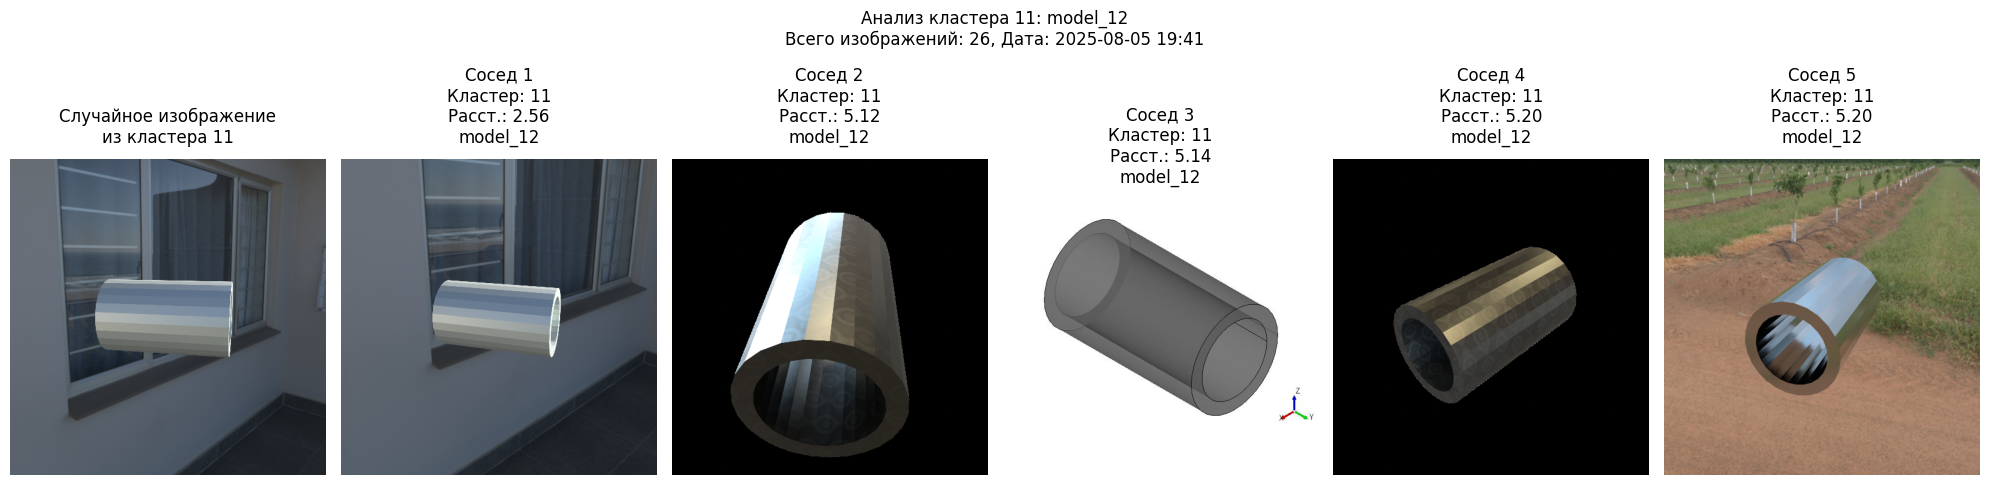

INFO:__main__:Анализ кластера 10 (model_11)...


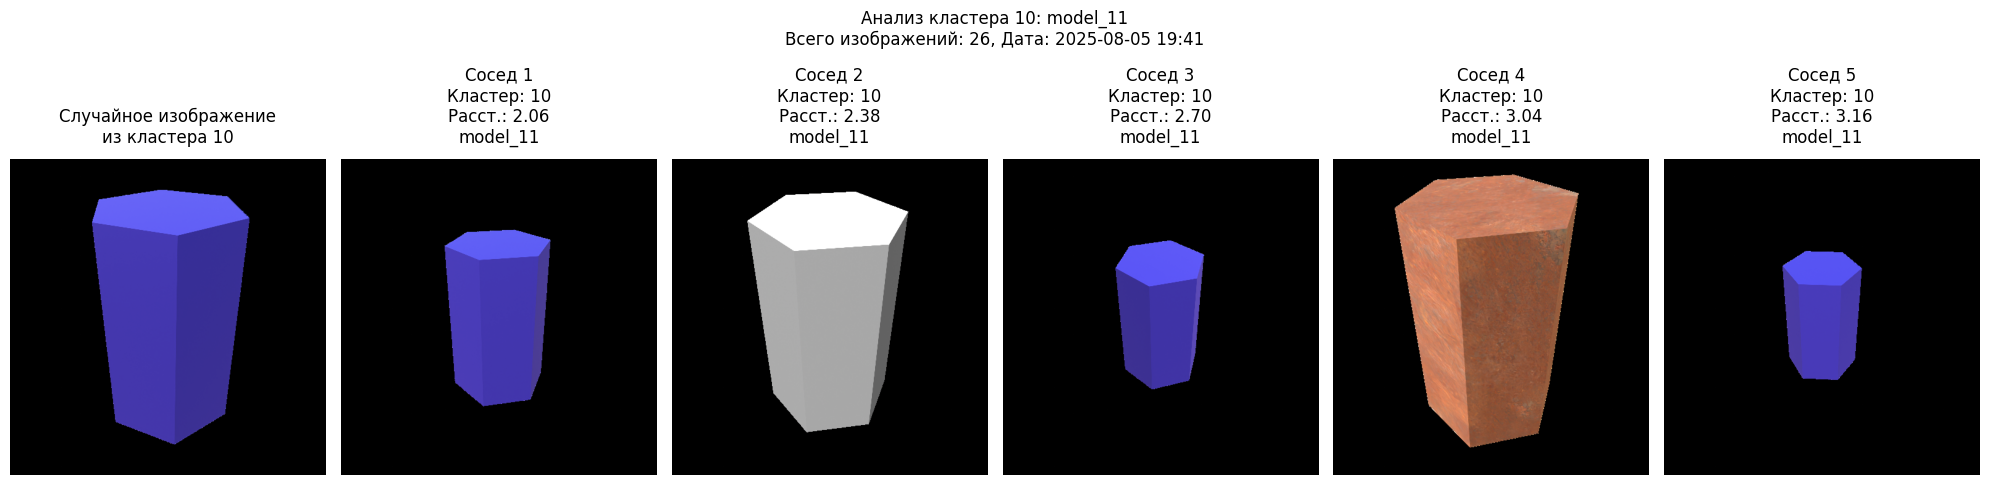

In [38]:
try:
    visualize_new_clusters_neighbors(
        new_folder_indices=[-1, -2],  # Последние два кластера
        k_neighbors=5,
        figsize=(20, 5),
        samples_per_cluster=1  # По 3 случайных примера из каждого кластера
    )
except Exception as e:
    logger.error(f"Ошибка при визуализации: {str(e)}")

In [39]:
def show_cluster_stats(labels, folder_names):
    """Показывает статистику по кластерам"""
    from collections import Counter
    counts = Counter(labels)
    print("\nТекущие кластеры:")
    for idx, count in counts.most_common():
        print(f"{idx}: {folder_names[idx]} - {count} изображений")

# После добавления новых кластеров:
show_cluster_stats(labels, folder_names)


Текущие кластеры:
0: model_1 - 26 изображений
1: model_10 - 26 изображений
2: model_2 - 26 изображений
3: model_3 - 26 изображений
4: model_4 - 26 изображений
5: model_5 - 26 изображений
6: model_6 - 26 изображений
7: model_7 - 26 изображений
8: model_8 - 26 изображений
9: model_9 - 26 изображений
10: model_11 - 26 изображений
11: model_12 - 26 изображений


In [49]:
def visualize_tsne_with_marked_points(paths=None, perplexity=30, random_state=42):
    """
    Визуализирует t-SNE с отметкой указанных изображений зелеными галочками.
    Работает даже без сохраненных путей изображений.
    """
    # 1. Загрузка основных данных
    try:
        embeddings = np.load('model_embeddings.npy')
        labels = np.load('model_labels.npy')
        folder_names = np.load('folder_names.npy')
        scaler = joblib.load('scaler.pkl')
        model = EmbeddingExtractor(EMBEDDING_SIZE).to(device)
        model.load_state_dict(torch.load('embedding_model.pth'))
        model.eval()
    except Exception as e:
        print(f"Ошибка загрузки основных данных: {e}")
        return

    # 2. t-SNE преобразование
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings)

    # 3. Визуализация кластеров
    plt.figure(figsize=(14, 12))
    colors = plt.cm.tab20(np.linspace(0, 1, len(folder_names)))
    
    for i in range(len(folder_names)):
        mask = (labels == i)
        if np.any(mask):
            plt.scatter(
                embeddings_2d[mask, 0], 
                embeddings_2d[mask, 1],
                color=colors[i],
                alpha=0.4,
                s=40,
                label=f'{folder_names[i]} (n={np.sum(mask)})',
                edgecolors='w',
                linewidth=0.3
            )

    # 4. Обработка и отметка указанных изображений
    if paths:
        # Загрузка центроидов, если есть
        centroids = None
        if os.path.exists('cluster_centroids.npy'):
            centroids = np.load('cluster_centroids.npy')
        
        for img_path in paths:
            try:
                # Загрузка и преобразование изображения
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img).unsqueeze(0).to(device)
                
                # Получение эмбеддинга
                with torch.no_grad():
                    emb = model(img_tensor).cpu().numpy()
                emb_norm = scaler.transform(emb)[0]
                
                # Находим ближайшую точку в t-SNE пространстве
                distances = np.linalg.norm(embeddings - emb_norm, axis=1)
                closest_idx = np.argmin(distances)
                x, y = embeddings_2d[closest_idx]
                cluster = labels[closest_idx]
                
                # Рисуем галочку
                plt.scatter(
                    x, y,
                    marker='$\u2713$',  # Символ галочки
                    s=500,
                    color='limegreen',
                    edgecolors='darkgreen',
                    linewidth=2,
                    label=f'Marked: {os.path.basename(img_path)} (cluster {cluster})'
                )
                
                # Подпись с расстоянием
                if centroids is not None and cluster < len(centroids):
                    dist = np.linalg.norm(emb_norm - centroids[cluster])
                    plt.text(x, y+0.5, f'd={dist:.2f}', 
                            ha='center', va='bottom',
                            bbox=dict(facecolor='white', alpha=0.7))
                
                print(f"Изображение {os.path.basename(img_path)} отмечено в кластере {cluster} ({folder_names[cluster]})")
                
            except Exception as e:
                print(f"Ошибка обработки {img_path}: {e}")

    # 5. Настройка графика
    plt.title('t-SNE Projection with Marked Images', pad=20)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(alpha=0.2)
    
    # Легенда без дубликатов
    handles, labels_legend = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels_legend, handles))
    plt.legend(
        unique.values(),
        unique.keys(),
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        frameon=True,
        title='Clusters & Marked'
    )

    plt.tight_layout()
    plt.show()

Изображение 0000_0.png отмечено в кластере 10 (model_11)
Изображение 0001_20.png отмечено в кластере 10 (model_11)
Изображение 0002_15.png отмечено в кластере 11 (model_12)
Изображение 0003_10.png отмечено в кластере 10 (model_11)
Изображение 0004_15.png отмечено в кластере 10 (model_11)
Изображение 0005_16.png отмечено в кластере 10 (model_11)
Изображение 0006_7.png отмечено в кластере 10 (model_11)
Изображение 0007_16.png отмечено в кластере 10 (model_11)
Изображение 0008_13.png отмечено в кластере 10 (model_11)
Изображение 0009_8.png отмечено в кластере 11 (model_12)
Изображение g0000_21.png отмечено в кластере 10 (model_11)
Изображение g0001_22.png отмечено в кластере 11 (model_12)


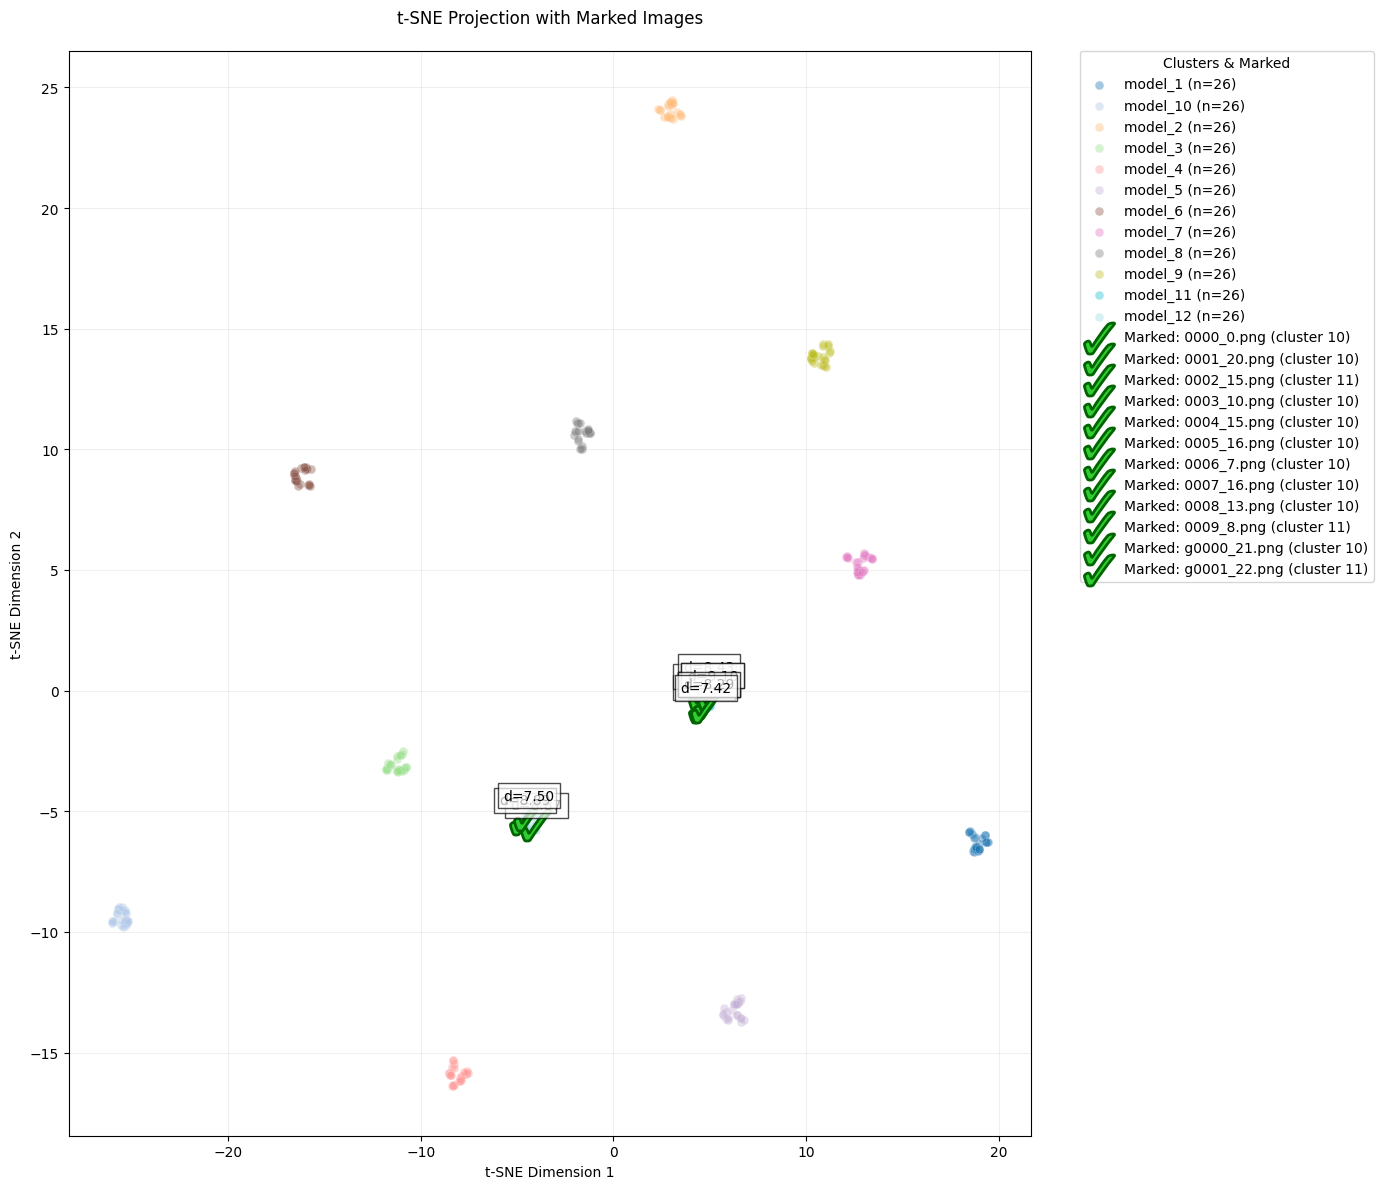

In [51]:
visualize_tsne_with_marked_points(
    paths=[
        'bited_images/0000_0.png',
        'bited_images/0001_20.png',
        'bited_images/0002_15.png',
        'bited_images/0003_10.png',
        'bited_images/0004_15.png',
        'bited_images/0005_16.png',
        'bited_images/0006_7.png',
        'bited_images/0007_16.png',
        'bited_images/0008_13.png',
        'bited_images/0009_8.png',
        'bited_images/g0000_21.png',
        'bited_images/g0001_22.png',
    ],
    perplexity=30,
)

In [52]:
# В блоке, где вы сохраняете данные (после extract_folder_embeddings), добавьте:
all_image_paths = []
for folder in model_folders:
    images = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    all_image_paths.extend([os.path.join(folder, img) for img in images])

np.save('image_paths.npy', np.array(all_image_paths))  # Сохраняем пути

In [53]:
def get_cluster_images(cluster_id):
    """
    Возвращает список путей к изображениям в указанном кластере.
    
    Args:
        cluster_id (int): Номер кластера (начинается с 0)
    
    Returns:
        list: Список путей к изображениям
    """
    try:
        # Загрузка данных
        labels = np.load('model_labels.npy')
        image_paths = np.load('image_paths.npy')
        folder_names = np.load('folder_names.npy')
        
        # Проверка существования кластера
        if cluster_id >= len(folder_names):
            print(f"Ошибка: кластер {cluster_id} не существует (макс. кластер: {len(folder_names)-1})")
            return []
        
        # Получение изображений кластера
        cluster_mask = (labels == cluster_id)
        cluster_images = image_paths[cluster_mask]
        
        print(f"Кластер {cluster_id} ({folder_names[cluster_id]}): {len(cluster_images)} изображений")
        return cluster_images.tolist()
    
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        return []

In [54]:
# Получить все изображения кластера 3
cluster_3_images = get_cluster_images(3)

# Вывести первые 5 путей
for i, path in enumerate(cluster_3_images[:5], 1):
    print(f"{i}. {path}")

# Визуализировать первые 3 изображения
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, img_path in enumerate(cluster_3_images[:3], 1):
    img = Image.open(img_path)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
plt.tight_layout()
plt.show()

Ошибка загрузки данных: boolean index did not match indexed array along axis 0; size of axis is 260 but size of corresponding boolean axis is 312


<Figure size 1500x500 with 0 Axes>